In [9]:
import altair as alt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

from collections import defaultdict
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import json

In [10]:
from kneed import KneeLocator
from sklearn.cluster import AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import Birch

# Load Data

In [11]:
# load TPM data
tpm_data_file = 'data/TPM_counts.tsv'
sample2condition_file = 'data/new_sample2condition.txt'
diagnostic_genes_file = 'data/diagnostic_genes.csv'
unstable_diag_genes_file = 'data/unstable_diagnostic_expression.csv'

# load TPM data
df = pd.read_csv(tpm_data_file, sep='\t').fillna('')


# load mapping from sample to condition
with open(sample2condition_file, 'r') as f:
    #     sample2condition = dict(x.strip().split() for x in f.readlines())
    sample2condition = json.load(f)

# load data for diagnostic genes:
df_diagnostics = pd.read_csv(diagnostic_genes_file)
df_diagnostics['Gene'] = df_diagnostics['Gene'].apply(
    lambda x: "EQU24_RS20550" if x == "MBURv2_160514" else x)
df_diagnostics


# Mission: Reorganize dataset into 98x4213 dataframe where
#     --> columns represent each locus
#     --> rows represent each sample present

df_raw_tpm = df.iloc[:, 10:].T
loci = df["locus_tag"]
df_raw_tpm = df_raw_tpm.set_axis(loci, axis=1)

df_raw_tpm

locus_tag,EQU24_RS00005,EQU24_RS00010,EQU24_RS00015,EQU24_RS00020,EQU24_RS00025,EQU24_RS00030,EQU24_RS00035,EQU24_RS00040,EQU24_RS00045,EQU24_RS00050,...,EQU24_RS22110,EQU24_RS22115,EQU24_RS22120,EQU24_RS22125,EQU24_RS22130,EQU24_RS22135,EQU24_RS22140,EQU24_RS22145,EQU24_RS22150,EQU24_RS22155
5GB1_ferm_Ack_QC_tpm,2.933003,1.607784,1.415515,3.200081,1.522728,2.013385,8.890269,1.632474,0.790911,0.446398,...,170.826337,0.973237,2.344352,2.331287,4.867523,2.300157,5.261582,9.389775,21.657488,27.832080
5GB1_ferm_WT_QC_tpm,6.033848,3.895284,2.549771,4.301580,3.797084,1.694449,9.506517,3.340407,2.160868,1.134421,...,259.349616,2.866741,1.856930,0.951269,3.972334,3.217944,12.526353,21.072962,42.254357,41.530602
5GB1_FM03_TR1_QC_tpm,48.864921,51.315629,33.906257,64.584281,74.801354,13.090237,50.320911,20.811187,21.910217,18.096708,...,6655.778183,56.948463,52.002311,60.628466,23.015801,104.488835,379.686212,500.129230,1191.565348,796.964423
5GB1_FM03_TR2_QC_tpm,52.197450,54.947425,29.979783,72.717824,62.709260,24.874673,71.255094,19.773190,19.421485,16.776993,...,6480.237054,50.243190,41.376658,66.581832,54.669612,103.864151,401.742811,495.262554,1232.784967,724.291958
5GB1_FM11_TR1_QC_tpm,25.751902,37.216017,21.716802,53.032824,46.348014,42.426259,58.772307,9.667881,8.212313,12.634273,...,6651.883413,25.635202,29.059082,59.545627,34.189659,78.264069,208.094267,260.011454,666.589153,461.697526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5GB1C-5G-N-BR2_tpm,33.432274,48.142385,22.006566,64.648318,39.358066,34.654512,107.541275,33.869275,23.770815,20.064562,...,9003.930101,20.600870,37.114422,39.499880,42.467068,30.766617,166.101675,59.523445,259.828426,404.714461
5GB1C-JG15-La-BR1_tpm,39.880174,45.465136,22.658157,69.119079,38.992158,67.033753,130.729298,39.968258,22.454067,18.039069,...,3318.767885,10.724405,39.422680,49.109710,46.810258,22.101468,96.169044,47.641158,134.795621,265.487592
5GB1C-JG15-La-BR2_tpm,38.355431,46.498139,22.753325,65.643179,35.870964,51.959561,120.575354,37.092594,20.769383,17.655632,...,3458.558649,15.496249,41.910716,53.086286,44.827579,19.753259,93.527806,60.667488,160.260255,308.428817
5GB1C-JG15-N-BR1_tpm,30.247582,37.152951,19.407103,57.590223,41.462392,44.527488,105.320613,27.798238,18.873435,15.578396,...,3997.726513,17.356475,41.685308,44.836637,47.307203,20.027390,89.780995,55.739018,174.197473,286.670085


In [12]:
# Clean Data:

# Remove FM 80 Fermentor Run from NO3_LowO2_Slow_Growth
# 5GB1_FM80_t2_TR1_tpm
df_raw_tpm = df_raw_tpm.drop("5GB1_FM80_t2_TR1_tpm")
# 5GB1_FM80_t4_TR1_tpm
df_raw_tpm = df_raw_tpm.drop("5GB1_FM80_t4_TR1_tpm")

# Remove the w/ Lanthanum samples that are not Joseph's

# 5GB1_vial_wLa_TR3_tpm
df_raw_tpm = df_raw_tpm.drop("5GB1_vial_wLa_TR3_tpm")
# 5GB1C-5G-La-BR1_tpm
df_raw_tpm = df_raw_tpm.drop("5GB1C-5G-La-BR1_tpm")
# 5GB1C-5G-La-BR2_tpm
df_raw_tpm = df_raw_tpm.drop("5GB1C-5G-La-BR2_tpm")

# Remove the w/o Lanthanum samples that are not Joseph's

# 5GB1_vial_woLa_TR2_tpm
df_raw_tpm = df_raw_tpm.drop("5GB1_vial_woLa_TR2_tpm")
# 5GB1C-5G-N-BR1_tpm
df_raw_tpm = df_raw_tpm.drop("5GB1C-5G-N-BR1_tpm")
# 5GB1C-5G-N-BR2_tpm
df_raw_tpm = df_raw_tpm.drop("5GB1C-5G-N-BR2_tpm")

# Re-Label the FM11 from LowO2_fast_growth as LowO2_low_iron_fast_growth
sample2condition['5GB1_FM11_TR1_QC_tpm'] = 'lowO2_low_iron_fast_growth'
sample2condition['5GB1_FM11_TR2_QC_tpm'] = 'lowO2_low_iron_fast_growth'

with open('data/new_sample2condition.txt', 'w') as file:
    # use `json.loads` to do the reverse
    file.write(json.dumps(sample2condition))

df_raw_tpm

locus_tag,EQU24_RS00005,EQU24_RS00010,EQU24_RS00015,EQU24_RS00020,EQU24_RS00025,EQU24_RS00030,EQU24_RS00035,EQU24_RS00040,EQU24_RS00045,EQU24_RS00050,...,EQU24_RS22110,EQU24_RS22115,EQU24_RS22120,EQU24_RS22125,EQU24_RS22130,EQU24_RS22135,EQU24_RS22140,EQU24_RS22145,EQU24_RS22150,EQU24_RS22155
5GB1_ferm_Ack_QC_tpm,2.933003,1.607784,1.415515,3.200081,1.522728,2.013385,8.890269,1.632474,0.790911,0.446398,...,170.826337,0.973237,2.344352,2.331287,4.867523,2.300157,5.261582,9.389775,21.657488,27.832080
5GB1_ferm_WT_QC_tpm,6.033848,3.895284,2.549771,4.301580,3.797084,1.694449,9.506517,3.340407,2.160868,1.134421,...,259.349616,2.866741,1.856930,0.951269,3.972334,3.217944,12.526353,21.072962,42.254357,41.530602
5GB1_FM03_TR1_QC_tpm,48.864921,51.315629,33.906257,64.584281,74.801354,13.090237,50.320911,20.811187,21.910217,18.096708,...,6655.778183,56.948463,52.002311,60.628466,23.015801,104.488835,379.686212,500.129230,1191.565348,796.964423
5GB1_FM03_TR2_QC_tpm,52.197450,54.947425,29.979783,72.717824,62.709260,24.874673,71.255094,19.773190,19.421485,16.776993,...,6480.237054,50.243190,41.376658,66.581832,54.669612,103.864151,401.742811,495.262554,1232.784967,724.291958
5GB1_FM11_TR1_QC_tpm,25.751902,37.216017,21.716802,53.032824,46.348014,42.426259,58.772307,9.667881,8.212313,12.634273,...,6651.883413,25.635202,29.059082,59.545627,34.189659,78.264069,208.094267,260.011454,666.589153,461.697526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5GB1_pA9_yellow_tpm,38.810668,52.461746,34.914128,80.850761,49.349547,38.829856,65.199396,28.421940,34.998158,37.011081,...,8978.523141,38.296718,48.623546,64.643789,40.333764,92.044879,403.009110,329.903989,679.393946,723.410948
5GB1C-JG15-La-BR1_tpm,39.880174,45.465136,22.658157,69.119079,38.992158,67.033753,130.729298,39.968258,22.454067,18.039069,...,3318.767885,10.724405,39.422680,49.109710,46.810258,22.101468,96.169044,47.641158,134.795621,265.487592
5GB1C-JG15-La-BR2_tpm,38.355431,46.498139,22.753325,65.643179,35.870964,51.959561,120.575354,37.092594,20.769383,17.655632,...,3458.558649,15.496249,41.910716,53.086286,44.827579,19.753259,93.527806,60.667488,160.260255,308.428817
5GB1C-JG15-N-BR1_tpm,30.247582,37.152951,19.407103,57.590223,41.462392,44.527488,105.320613,27.798238,18.873435,15.578396,...,3997.726513,17.356475,41.685308,44.836637,47.307203,20.027390,89.780995,55.739018,174.197473,286.670085


In [13]:
samples = list(sample2condition.keys())
# transpose dataframe to make experiments the rows and genes the columns
df_T = df.set_index('locus_tag')[samples].T.reset_index().rename(
    columns={'index': 'sample'})

# your code here (add exp_condition column)
df_T['exp_condition'] = df_T['sample'].apply(lambda x: sample2condition.get(x))
df_T

df_Avg = df_T.groupby(['exp_condition']).mean()
df_Avg

locus_tag,EQU24_RS00005,EQU24_RS00010,EQU24_RS00015,EQU24_RS00020,EQU24_RS00025,EQU24_RS00030,EQU24_RS00035,EQU24_RS00040,EQU24_RS00045,EQU24_RS00050,...,EQU24_RS22110,EQU24_RS22115,EQU24_RS22120,EQU24_RS22125,EQU24_RS22130,EQU24_RS22135,EQU24_RS22140,EQU24_RS22145,EQU24_RS22150,EQU24_RS22155
exp_condition,,,,,,,,,,,,,,,,,,,,,
LanzaTech,25.626702,55.711920,11.804042,76.880335,43.737438,27.940983,35.296053,25.926725,23.461781,25.929209,...,7420.641716,16.014544,15.947067,16.286482,9.514666,46.013885,354.315359,157.364073,571.458102,613.084675
MeOH,23.323155,18.905775,18.443916,18.257805,16.950643,12.367795,43.805536,9.660950,7.292145,9.568570,...,1298.247682,15.614619,20.198066,25.994364,20.950234,28.709983,93.606437,161.518124,496.980651,280.334047
NO3_lowO2_slow_growth,32.040358,43.646760,21.341623,62.257687,41.674925,31.911455,57.839768,16.875694,14.916147,13.952268,...,6497.858109,26.263485,28.935133,23.515245,26.422667,35.157264,178.986199,164.073806,433.428735,493.885115
NoCu,44.338687,59.619360,28.258717,56.808319,49.829406,38.384652,81.520362,40.491969,36.566500,27.046153,...,8345.775345,43.055124,34.370565,44.409579,34.591933,65.329879,253.598495,273.274694,731.042190,1087.611126
NoLanthanum,33.434023,43.679839,23.162675,57.287047,42.357072,41.931657,102.503601,30.216787,19.452312,17.138966,...,5085.627409,16.413284,35.578138,44.613117,43.191743,21.917260,109.773330,67.267718,211.565175,328.933746
WT_control,34.988452,38.272163,15.495930,54.855025,35.396786,26.817623,59.558466,24.797995,27.925137,22.640284,...,4939.367129,18.248719,21.027514,31.490596,45.810743,36.195898,172.298263,181.468991,403.551659,648.122601
WithLanthanum,35.452185,41.782237,20.634554,57.120166,34.248335,46.191637,110.711781,31.803805,19.428086,17.304281,...,3942.947792,15.962203,34.308829,49.206725,39.990662,21.210809,98.090610,73.106973,194.379586,319.988959
aa3_KO,26.849583,45.489035,11.962099,55.846659,33.097353,28.718155,50.249664,21.490715,24.790508,18.955507,...,5355.094603,16.236806,20.836285,28.298842,40.627394,30.065630,181.790564,153.928317,376.664997,657.228922
crotonic_acid,38.684021,52.507256,33.132559,77.849631,49.837247,37.332021,69.675355,32.001867,35.856260,35.008462,...,8680.904376,42.175374,47.879804,58.961083,43.069352,81.481463,365.899345,315.553709,614.920997,676.638496


In [14]:
# Preprocessing before clustering

scalar = StandardScaler()
scaled_tpm_data = scalar.fit_transform(df_raw_tpm)
df_scaled_tpm = pd.DataFrame(data=scaled_tpm_data, index=df_raw_tpm.index,
                             columns=df_raw_tpm.columns)
df_scaled_tpm

locus_tag,EQU24_RS00005,EQU24_RS00010,EQU24_RS00015,EQU24_RS00020,EQU24_RS00025,EQU24_RS00030,EQU24_RS00035,EQU24_RS00040,EQU24_RS00045,EQU24_RS00050,...,EQU24_RS22110,EQU24_RS22115,EQU24_RS22120,EQU24_RS22125,EQU24_RS22130,EQU24_RS22135,EQU24_RS22140,EQU24_RS22145,EQU24_RS22150,EQU24_RS22155
5GB1_ferm_Ack_QC_tpm,-2.565358,-2.215543,-2.509824,-2.681133,-2.284698,-1.988010,-2.516952,-1.769026,-1.725581,-2.359272,...,-2.172536,-1.965575,-2.541545,-2.083028,-1.586230,-2.245028,-2.131013,-2.111506,-1.982084,-1.665367
5GB1_ferm_WT_QC_tpm,-2.339395,-2.110042,-2.391001,-2.624385,-2.152125,-2.011621,-2.492881,-1.642058,-1.614046,-2.271651,...,-2.141721,-1.838425,-2.586222,-2.175661,-1.641712,-2.209386,-2.071138,-2.022032,-1.929916,-1.639230
5GB1_FM03_TR1_QC_tpm,0.781775,0.077011,0.893865,0.481305,1.986730,-1.167982,-0.898623,-0.343280,-0.006160,-0.111471,...,0.084873,1.793217,2.010083,1.830159,-0.461441,1.723493,0.954953,1.646734,0.981062,-0.197873
5GB1_FM03_TR2_QC_tpm,1.024622,0.244512,0.482532,0.900335,1.281879,-0.295571,-0.080909,-0.420444,-0.208780,-0.279539,...,0.023767,1.342951,1.036140,2.229778,1.500391,1.699233,1.136741,1.609463,1.085463,-0.336531
5GB1_FM11_TR1_QC_tpm,-0.902508,-0.573271,-0.383087,-0.113812,0.328178,1.003787,-0.568502,-1.171673,-1.121370,-0.807123,...,0.083517,-0.309500,-0.092884,1.757474,0.231090,0.705048,-0.459289,-0.192165,-0.348599,-0.837557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5GB1_pA9_yellow_tpm,0.049105,0.129871,0.999448,1.319334,0.503138,0.737542,-0.317452,0.222504,1.059390,2.297310,...,0.893419,0.540734,1.700386,2.099687,0.611888,1.240229,1.147178,0.343095,-0.316167,-0.338212
5GB1C-JG15-La-BR1_tpm,0.127042,-0.192817,-0.284472,0.714932,-0.100596,2.825499,2.242223,1.080858,0.038117,-0.118812,...,-1.076739,-1.310775,0.857039,1.056965,1.013286,-1.476040,-1.381764,-1.818564,-1.695527,-1.211923
5GB1C-JG15-La-BR2_tpm,0.015932,-0.145174,-0.274502,0.535858,-0.282531,1.709545,1.845598,0.867081,-0.099041,-0.167643,...,-1.028078,-0.990341,1.085091,1.323892,0.890404,-1.567233,-1.403533,-1.718805,-1.631030,-1.129992
5GB1C-JG15-N-BR1_tpm,-0.574901,-0.576179,-0.625048,0.120980,0.043394,1.159342,1.249730,0.176138,-0.253399,-0.432183,...,-0.840394,-0.865425,1.064430,0.770136,1.044086,-1.556587,-1.434414,-1.756548,-1.595730,-1.171508


In [15]:
# Preprocessing before clustering
scalar = StandardScaler()

scaled_tpm_data = scalar.fit_transform(df_Avg)
df_avg_scaled_tpm = pd.DataFrame(data=scaled_tpm_data, index=df_Avg.index,
                                 columns=df_Avg.columns).T
df_avg_scaled_tpm

exp_condition,LanzaTech,MeOH,NO3_lowO2_slow_growth,NoCu,NoLanthanum,WT_control,WithLanthanum,aa3_KO,crotonic_acid,highCu,highO2_slow_growth,lowCH4,lowCu,lowO2_fast_growth,lowO2_low_iron_fast_growth,lowO2_slow_growth,medCu,slow_growth,uMax,unknown
locus_tag,,,,,,,,,,,,,,,,,,,,
EQU24_RS00005,-0.909002,-1.113499,-0.339628,0.752159,-0.215905,-0.077910,-0.036742,-0.800440,0.250164,1.064007,2.566352,-0.448025,0.630081,0.083214,-0.490574,-1.831540,0.802957,0.046266,1.435479,-1.367412
EQU24_RS00010,0.375879,-1.578377,-0.264732,0.583348,-0.262975,-0.550101,-0.363730,-0.166914,0.205724,1.617663,2.673926,-0.802287,0.667229,-0.243435,-0.529768,-1.370163,0.869095,0.017351,0.602563,-1.480295
EQU24_RS00015,-1.277528,-0.537212,-0.214131,0.557094,-0.011092,-0.865899,-0.292966,-1.259905,1.100505,1.144154,2.406532,-0.533059,0.619531,0.508193,0.170814,-1.469626,0.685363,-0.692150,1.189759,-1.228376
EQU24_RS00020,1.214163,-2.289077,0.340324,0.014674,0.043282,-0.102053,0.033310,-0.042794,1.272088,1.001425,1.340101,-0.813271,0.298830,-0.517893,-0.134374,-1.953208,0.527100,0.513216,0.865298,-1.611141
EQU24_RS00025,0.177218,-1.840263,0.021877,0.636042,0.073254,-0.450969,-0.537466,-0.624154,0.636633,0.547380,2.745112,-0.734405,0.720953,-0.879293,0.812341,-1.757539,0.552483,0.249991,0.546316,-0.895512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EQU24_RS22135,-0.224448,-0.941750,-0.674489,0.576261,-1.223329,-0.631435,-1.252614,-0.885554,1.245795,1.586486,0.024662,0.371401,0.634446,0.887685,0.727363,-1.476565,1.375760,-0.882123,1.597450,-0.835001
EQU24_RS22140,1.186216,-1.284894,-0.475628,0.231579,-1.131657,-0.539019,-1.242391,-0.449047,1.296014,1.078694,-0.085112,-0.021489,0.610629,1.230015,-0.186811,-1.506645,1.050734,-0.585724,1.915108,-1.090569
EQU24_RS22145,-0.684908,-0.648104,-0.625461,0.342034,-1.483142,-0.471344,-1.431407,-0.715348,0.716616,1.345035,0.083810,0.552406,0.700475,1.399826,0.540569,-1.335084,1.262869,-0.438083,1.907212,-1.017969


In [16]:
# Log Ratio Data --> 

# list of all samples
samples = list(sample2condition.keys())

df_T = df.set_index('locus_tag')[samples].T.reset_index().rename(columns={'index':'sample'})

# your code here (add exp_condition column)
df_T['exp_condition'] = df_T['sample'].apply(lambda x: sample2condition.get(x))

df_Avg = df_T.groupby(['exp_condition']).mean()

umax_averages = df_Avg.T.uMax.apply(lambda x: x + 1).to_dict()

df_raw_tpm = np.add(df_raw_tpm, 0.05)

df_log_ratio = np.log(df_raw_tpm / list(umax_averages.values())).T

df_log_ratio.set_axis(umax_averages.keys())


,5GB1_ferm_Ack_QC_tpm,5GB1_ferm_WT_QC_tpm,5GB1_FM03_TR1_QC_tpm,5GB1_FM03_TR2_QC_tpm,5GB1_FM11_TR1_QC_tpm,5GB1_FM11_TR2_QC_tpm,5GB1_FM12_TR1_tpm,5GB1_FM12_TR1_QC_tpm,5GB1_FM12_TR2_tpm,5GB1_FM12_TR2_QC_tpm,...,5GB1_FM_85_TR1_tpm,5GB1_FM_85_TR2_tpm,5GB1_FM_86_TR1_tpm,5GB1_FM_87_TR1_tpm,5GB1_pA9_red_tpm,5GB1_pA9_yellow_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm
EQU24_RS00005,-2.878038,-2.165331,-0.080886,-0.014978,-0.720521,-0.416245,-0.625538,-0.620652,-0.620033,-0.585807,...,-0.760126,-0.603701,-0.145171,-0.784305,-0.317525,-0.310986,-0.283836,-0.322770,-0.559901,-0.250144
EQU24_RS00010,-3.605085,-2.738046,-0.171597,-0.103280,-0.492485,-0.418088,-0.798649,-0.753719,-0.831575,-0.819483,...,-0.255647,-0.329717,-0.654126,-0.305230,-0.147798,-0.149530,-0.292522,-0.270080,-0.494178,-0.141173
EQU24_RS00015,-3.171227,-2.598011,-0.028361,-0.151244,-0.473048,-0.224035,-0.742775,-0.805342,-0.741667,-0.719712,...,-1.334244,-0.857165,-0.543472,-1.173404,-0.106595,0.000889,-0.430710,-0.426528,-0.585222,-0.156107
EQU24_RS00020,-3.098576,-2.806717,-0.108511,0.010018,-0.305403,-0.258254,-0.670534,-0.681262,-0.651234,-0.696979,...,-0.207792,-0.301926,-0.670750,0.012833,0.038878,0.115967,-0.040702,-0.092261,-0.223035,-0.052516
EQU24_RS00025,-3.451947,-2.557443,0.410746,0.234548,-0.067502,0.156415,-0.591207,-0.489324,-0.612536,-0.626963,...,-0.506612,-0.310571,-0.313462,-0.360544,0.014736,-0.004817,-0.240116,-0.323437,-0.178766,-0.208973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EQU24_RS22135,-3.655989,-3.326310,0.139088,0.133094,-0.149744,-0.420537,-0.434909,-0.462635,-0.314292,-0.272800,...,-1.255744,-0.974779,-0.606825,-1.378946,-0.248241,0.012348,-1.412567,-1.524624,-1.510877,-1.309418
EQU24_RS22140,-4.399034,-3.537106,-0.129447,-0.072988,-0.730693,-0.717681,-0.746840,-0.746844,-0.715491,-0.681644,...,-0.864618,-0.866970,-1.017830,-0.829809,-0.273354,-0.069841,-1.502297,-1.530131,-1.570994,-1.194481
EQU24_RS22145,-3.866393,-3.060964,0.103641,0.093864,-0.550407,-0.307984,-0.404825,-0.377341,-0.366121,-0.350363,...,-1.282328,-0.902543,-0.896833,-0.923271,-0.403373,-0.312372,-2.246579,-2.005093,-2.089748,-1.914646
EQU24_RS22150,-4.094819,-3.427586,-0.089411,-0.055405,-0.670227,-0.415197,-0.453014,-0.464075,-0.474722,-0.444352,...,-1.442261,-1.073516,-1.164732,-1.179417,-0.861653,-0.651201,-2.268346,-2.095365,-2.012000,-2.071553


In [17]:
df_Avg_pseudocounts = np.add(df_Avg, 0.05)
df_avg_log_ratio = np.log(df_Avg_pseudocounts / list(umax_averages.values())).T

df_avg_log_ratio.set_axis(umax_averages.keys())
df_avg_log_ratio

# Preprocessing before clustering --> used to get scaled 
scalar = StandardScaler()

scaled_tpm_log_data = scalar.fit_transform(df_log_ratio)
df_log_ratio_scaled_tpm = pd.DataFrame(data=scaled_tpm_log_data, index=df_log_ratio.index,
                             columns=df_log_ratio.columns)

scaled_df_avg_log_ratio = scalar.fit_transform(df_avg_log_ratio)
df_avg_log_ratio_scaled_tpm = pd.DataFrame(data=scaled_df_avg_log_ratio, index=df_avg_log_ratio.index,
                             columns=df_avg_log_ratio.columns)


df_log_ratio_scaled_tpm 
df_avg_log_ratio_scaled_tpm

exp_condition,LanzaTech,MeOH,NO3_lowO2_slow_growth,NoCu,NoLanthanum,WT_control,WithLanthanum,aa3_KO,crotonic_acid,highCu,highO2_slow_growth,lowCH4,lowCu,lowO2_fast_growth,lowO2_low_iron_fast_growth,lowO2_slow_growth,medCu,slow_growth,uMax,unknown
locus_tag,,,,,,,,,,,,,,,,,,,,
EQU24_RS00005,-0.515808,-0.012058,-0.480048,-0.163349,-0.648447,-0.037469,-0.491013,-0.410117,-0.485123,0.085206,0.060397,-0.186470,-0.136377,-0.203679,-0.487435,-0.243069,0.044174,-0.122244,0.185208,-0.620522
EQU24_RS00010,0.480568,-0.659004,-0.218643,0.075821,-0.485571,-0.114821,-0.462526,0.094641,-0.209870,0.873114,0.504025,-0.305931,0.204399,-0.103679,-0.283817,0.062219,0.461263,0.103303,0.191813,-0.798028
EQU24_RS00015,-1.072637,0.327816,-0.461533,-0.212764,-0.583017,-0.648530,-0.633792,-0.917224,-0.048206,0.220238,0.138747,-0.385615,-0.106453,0.142845,-0.057250,-0.235794,0.034638,-0.609406,0.158782,-0.753895
EQU24_RS00020,0.723618,-1.032390,0.072132,-0.253222,-0.352283,0.183488,-0.292974,0.144541,0.167185,0.346152,-0.108216,-0.132304,-0.051795,-0.311922,0.060748,-0.078771,0.169326,0.274118,0.198566,-0.532597
EQU24_RS00025,0.424262,-0.479325,0.028098,0.116538,-0.261659,0.082847,-0.454102,-0.051229,0.045575,0.265104,0.450111,0.011533,0.240761,-0.573878,0.722346,0.029248,0.311967,0.268652,0.181731,-0.011128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EQU24_RS22135,-0.445389,-0.627550,-1.170665,-0.396450,-1.877416,-0.819438,-1.715711,-0.966683,-0.144739,0.277257,-1.123350,0.097626,-0.295041,0.153868,0.071796,-0.825055,0.213758,-1.168263,0.206290,-0.784262
EQU24_RS22140,0.309593,-1.327737,-1.065740,-0.706776,-1.812366,-0.818297,-1.749368,-0.654022,-0.239402,-0.195778,-1.305006,-0.407547,-0.418638,0.243782,-0.820586,-0.906017,-0.091223,-0.946392,0.229381,-1.159766
EQU24_RS22145,-1.028264,-0.395724,-1.265702,-0.657315,-2.492508,-0.803695,-2.140667,-0.926349,-0.555916,-0.028408,-1.210127,0.079368,-0.380479,0.362696,-0.218650,-0.747930,0.020182,-0.861652,0.229635,-1.151259


In [18]:
df_avg_log_ratio_scaled_tpm.to_csv("data/avg_log_ratio_scaled.csv")

In [19]:
standard_cluster_evals = ["sse", "silhouette", "calinski-harabasz", "davies-bouldin"]

# Functions

## Search Space Scanning

### kMeans

In [70]:
# Set-Up

kwargs_for_kmeans = {
    "init": "k-means++"
    ,"n_init": 4, 
    "max_iter": 400
    , "random_state": 42
}

font = {
    'family' : 'normal', 
    'weight' : 'normal', 
    'size' : 10
}

In [79]:
# Random Start

random_kwargs_for_kmeans = {
    "init": "random"
    ,"n_init": 4, 
    "max_iter": 400
}

font = {
    'family' : 'normal', 
    'weight' : 'normal', 
    'size' : 10
}

In [21]:
# df_tpm ==> the tpm data 
# x_min, x_max ==> small + large values of k clusters
# 
# returns [k, inertia, labels] 
def scan_kmeans_space(df_tpm, x_min, x_max):   
    
    scan_kmeans_results = []
    
    for k_cluster_num in range(x_min, x_max):
        kmeans = KMeans(n_clusters=k_cluster_num, **kwargs_for_kmeans)

        kmeans.fit(df_tpm)
        
        scan_kmeans_results.append([kmeans.labels_, k_cluster_num, kmeans.inertia_])
    
    return scan_kmeans_results

### DBSCAN

In [22]:
# df_tpm ==> the tpm data 
# 
# returns [eps, min_samples, num_clusters, labels] 
def scan_dbscan_space(df_tpm, eps_start, eps_end, min_sample_start, min_sample_end):   
    
    scan_dbscan_results = []
    
    # parameter 1: minimum samples
    for min_sample in range(min_sample_start, min_sample_end):

        # parameter 2: epsilon
        for e_val in np.arange(eps_start, eps_end, 0.25):
            dbscan = DBSCAN(eps= e_val, min_samples= min_sample)
            search_gene_clusters_dbscan = dbscan.fit(df_tpm)

            search_labels_dbscan = search_gene_clusters_dbscan.labels_
            num_clusters = len(set(search_labels_dbscan))
            
            scan_dbscan_results.append([search_labels_dbscan, e_val, min_sample, num_clusters])
            
    return scan_dbscan_results

### Agglomerative

In [23]:
# df_tpm ==> the tpm data 
# x_min, x_max ==> small + large values of k clusters
# 
# returns [eps, min_samples, num_clusters, labels] 
def scan_agglomerative_space(df_tpm, linkage_methods, x_min, x_max):   
    
    scan_agglomerative_results = []
    
    for linkage in linkage_methods:
        for k_cluster_num in range(x_min, x_max):
            agg_cluster = AgglomerativeClustering(linkage= linkage, n_clusters=k_cluster_num)

            agg_cluster.fit(df_tpm)

            scan_agglomerative_results.append([agg_cluster.labels_, k_cluster_num, linkage])

    return scan_agglomerative_results

### BIRCH

In [24]:
def scan_birch_space(df_tpm, threshold_min, threshold_max, branching_factor_min, branching_factor_max, x_min, x_max):
    
    scan_birch_results = []
    
    for t_val in np.arange(threshold_min, threshold_max, 0.05):
        for bf_val in range(branching_factor_min, branching_factor_max):  
            for k_cluster_num in range(x_min, x_max): 
                
                birch = Birch(threshold = t_val, branching_factor = bf_val, n_clusters = k_cluster_num)
                
                birch.fit(df_tpm)
                
                scan_birch_results.append([birch.labels_, t_val, bf_val, k_cluster_num])
    
    return scan_birch_results
    

### kMedoids

In [25]:
# df_tpm ==> the tpm data 
# x_min, x_max ==> small + large values of k clusters
# 
# returns [k, inertia, labels] 
def scan_kmedoids_space(df_tpm, x_min, x_max):   
    
    scan_kmedoids_results = []
    
    for k_cluster_num in range(x_min, x_max):
       
        kmedoids = KMedoids(n_clusters= k_cluster_num,  random_state=0).fit(df_tpm)

        kmedoids.fit(df_tpm)
        
        scan_kmedoids_results.append([kmedoids.labels_, k_cluster_num, kmedoids.inertia_])
    
    return scan_kmedoids_results

## Evaluation Metric Generation

### Score Generator

 - SSE (within cluster), 
 - Silhouette Score, 
 - Calinski-Habasz Score, 
 - Davies-Bouldin Index  

**SSE is only for kMeans since density-based clusters do have centroids, and subsequent SSE score cannot be calculated**

In [26]:
# clustering_method = kMeans or DBSCAN
# score_type = note above header
def score_generator(clustering_method, score_type, scan_results, df_tpm):
    
    if score_type == "sse" and clustering_method not in ["kmeans", "kmedoids"]: 
        # since sse (within clusters) is able by solely kmeans
        return None
    
    scores = []
    
    for scan in scan_results:
    
        # PARAMETERS
        
        param_0 = scan[0] # labels
        param_1 = scan[1] # k in kmeans, eps in dbscan, num cluster in agg, threshold in birch
        param_2 = scan[2] # inertia (sse) in kmean, min_val in dbscan, linkage in agg, branching factor in birch        
        if clustering_method in ["dbscan", "birch"]: 
            param_3 = scan[3] # number of clusters tracked as auxillary metric in dbscan, n_clusters in birch
            
            
        # SCORES
    
        if score_type == "sse": 
            # assume that the results are solely from kMeans
            scores.append([param_2, param_1])
            

        elif score_type == "silhouette":
            
            if clustering_method in ["dbscan", "birch"]: 
                scores.append([silhouette_score(df_tpm, param_0),  param_1,  param_2, param_3])
            elif clustering_method in ["kmeans", "kmedoids"]: 
                scores.append([silhouette_score(df_tpm, param_0),  param_1])
            else: 
                scores.append([silhouette_score(df_tpm, param_0),  param_1,  param_2])

        elif score_type == "calinski-harabasz":
            if clustering_method in ["dbscan", "birch"]: 
                scores.append([calinski_harabasz_score(df_tpm, param_0),  param_1,  param_2, param_3])
            elif clustering_method in ["kmeans", "kmedoids"]: 
                scores.append([calinski_harabasz_score(df_tpm, param_0),  param_1])
            else: 
                scores.append([calinski_harabasz_score(df_tpm, param_0),  param_1,  param_2])

        elif score_type == "davies-bouldin":
            if clustering_method in ["dbscan", "birch"]: 
                scores.append([davies_bouldin_score(df_tpm, param_0),  param_1,  param_2, param_3])
            elif clustering_method in ["kmeans", "kmedoids"]: 
                scores.append([davies_bouldin_score(df_tpm, param_0),  param_1])
            else: 
                scores.append([davies_bouldin_score(df_tpm, param_0),  param_1,  param_2])

        else: 
            return None

    return scores

## Plotting

### Evaluation Metric Subplots

#### Partitional - kMeans and kMedoids

In [27]:
# Graph Evaluation Metrics for kMeans

def plot_partitional_scores(scores, x_label, y_label, title):
    
    df_scores = pd.DataFrame(scores)
    
    scores_y = df_scores[0]
    num_clusters_x = df_scores[1]
    
    
    # Plot the elbow
    elbow_plot = sns.lineplot(x=range(min(num_clusters_x), max(num_clusters_x) + 1), y=scores_y,
                              marker="o", size=3, legend=False)
    
    elbow_plot.set_xlabel(x_label, fontsize = 15)
    elbow_plot.set_ylabel(y_label, fontsize = 15)
    elbow_plot.set_title(title, fontsize = 17)
    

#### DBSCAN

In [28]:
# Graph Evaluation Metrics for DBSCAN

# params = {[score, eps, min_samples], [score, eps, min_samples}
def plot_dbscan_scores(scores, x_label, y_label, title, palette):
    
    # Plot Idea: 
    # eps on x, min_samples on y, and color of dot: score
    
    df_scores = pd.DataFrame(scores)
    
    scores_color = df_scores[0]
    eps_x = df_scores[1]
    min_samples_y = df_scores[2]
    
    fig = sns.scatterplot(x = eps_x, y = scores_color, hue = min_samples_y, s = 60, palette= palette)
    
    plt.xlabel(x_label, fontsize = 15)
    plt.ylabel(y_label, fontsize = 15)
    plt.title(title, fontsize = 17)
    
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 2)
    
    plt.show(fig)
    
    

#### Agglomerative

In [29]:
# Graph Evaluation Metrics for Agglomerative Clustering

def plot_agglomerative_scores(scores, x_label, y_label, title, palette):
    
    # Plot Idea: for index, score_method in enumerate(standard_cluster_evals):
 
    df_scores = pd.DataFrame(scores)
    
    scores_y = df_scores[0]
    n_clusters_x = df_scores[1]
    linkage_method_color = df_scores[2]
    
    fig = sns.scatterplot(x = n_clusters_x, y = scores_y, hue = linkage_method_color, s = 60, palette= palette)
    
#     old_labels, _= fig.get_legend_handles_labels()
#     new_labels = ['ward', 'average', 'complete', 'single']
#     fig.legend(old_labels, new_labels)
        
    plt.xlabel(x_label, fontsize = 15)
    plt.ylabel(y_label, fontsize = 15)
    plt.title(title, fontsize = 17)
    
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 2)
    
    plt.show(fig)    

#### BIRCH

In [30]:
# Graph Evaluation Metrics for BIRCH Clustering

# params = {[score, threshold, braching factor, n_cluster]}
def plot_birch_scores(scores, x_label, y_label, title, palette, method):
    
    # Plot Idea:  
    
    df_scores = pd.DataFrame(scores)

    df_scores.columns = ["score","threshold","breaking_factor", "k_cluster_num"] 


    fill = 'threshold:N'
    size = 'breaking_factor:N'
    x_axis = 'k_cluster_num:N'
    y_axis = 'score:Q'

    chart = alt.Chart(df_scores, 
                      title= title,
                      height=500,
                      width=500
    ).mark_point(strokeOpacity=1.0).encode(
         x= x_axis,
         y= y_axis,
         size= size,
         fill= fill,
         tooltip=[fill, size, x_axis, alt.Tooltip(y_axis, title = method)], 
         
    ).interactive()
    
    chart.encoding.x.title = x_label
    chart.encoding.y.title = y_label
    
    #     plt.xlabel(x_label, fontsize = 15)
#     plt.ylabel(y_label, fontsize = 15)
#     plt.title(title, fontsize = 17)
    
#     plt.legend(bbox_to_anchor = (1.05, 1), loc = 2)
    
    return chart

#### Other Auxillary Plots

In [31]:
def plot_pca_var(pca, 
                 title="Variance explained by PCA components", tag = None):
    
    # title tag
    if tag:
        title = title + " (%s)"%tag
        
    # plot cumulative variance across components
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(title)
    plt.show()
    
    # plot individual explained variances for each component
    plt.bar(range(len(pca.explained_variance_ratio_)), 
            pca.explained_variance_ratio_,
            label="individual explained variance")
    
    plt.step(range(len(pca.explained_variance_ratio_)), 
             np.cumsum(pca.explained_variance_ratio_),
             label="cumulative explained variance",
             c='red')
    
    plt.xlabel('Number of Components')
    plt.ylabel("Explained Variance")
    plt.title(title)
    plt.legend(loc='best')
    plt.show()
    

In [32]:
def clusterCompositionPlot(clusterNums, dataPointNum, title_add):
    plt.bar(clusterNums, dataPointNum)
    title = "Composition of Clusters of " + title_add
    plt.title(title, fontsize = 17)
    plt.xlabel("Cluster Number", fontsize = 15)
    plt.ylabel("Number of Datapoints", fontsize = 15)

### Clustering

#### Partitional Methods

In [33]:
def plot_partitional_method(n_clusters, data, xlim, ylim, figsize = (12, 12), check_altair = False, method = "kmeans"): 
    # Plotting our clusters!
    n_clusters= n_clusters
    
    if method == "kmeans": 
        kmeans = KMeans(n_clusters= n_clusters, **kwargs_for_kmeans)
        labels = kmeans.fit_predict(data)
    else: 
        kmedoids = KMedoids(n_clusters= n_clusters, random_state=0)
        labels = kmedoids.fit_predict(data)
    
    pca = PCA(2)

    plt.figure(figsize= figsize)

    # Use PCA library in sklearn to fit and transform desired raw tpm data for each sample 
    dim_reduced_scaled = pca.fit_transform(data)

    # create dataframe with array + keep track of conditions so that its easy to grab the colors for plotting
    df_dim_reduced_scaled = pd.DataFrame(dim_reduced_scaled)

    df_dim_reduced_scaled = df_dim_reduced_scaled.set_axis(["PC1", "PC2"], axis = 1)

    df_dim_reduced_scaled['label'] = labels
    
    if not check_altair:
        freqs = df_dim_reduced_scaled['label'].unique()
        colors = sns.color_palette('Set2', n_colors=len(freqs))  # get a number of colors
        cmap = dict(zip(freqs, colors))  # zip freqs to colors and create a dict

        ax = sns.scatterplot(x = df_dim_reduced_scaled["PC1"], y = df_dim_reduced_scaled["PC2"], hue = df_dim_reduced_scaled['label'], legend='full', palette=cmap)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        ax.set_xlabel("PC 1", fontsize = 15)
        ax.set_ylabel("PC 2", fontsize = 15)
        title = method + " Clustering where k = " + str(n_clusters)
        ax.set_title(title, fontsize = 20)

        plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
        plt.show()
    
    else:
        # build scatter plot
        def pc_chart(x,y):
            ''' Same chart, change which pcs provided '''
            # pc1 and 2
            title = method + " Clustering where k = " + str(n_clusters)
            chart = alt.Chart(df_dim_reduced_scaled,
                                title= title,
                                height=500,
                                width=500
                               ).mark_circle().encode(
                x=x,
                y=y


            ).interactive()

            return chart

        chart12 = pc_chart('PC1:Q', 'PC2:Q')
        display(chart12)
    return labels

#### Denisty-Based Methods

In [34]:
<NOT YET COMPLETED>

def plot_hierarchical_method(k_cluster_num, linkage, data, xlim, ylim, figsize = (12, 12), check_altair = False, method = "agglomerative"): 
    # Plotting our clusters!
    
    if method == "dbscan": 
        agg_cluster = AgglomerativeClustering(linkage= linkage, n_clusters=k_cluster_num)
        labels = agg_cluster.fit(df_tpm).labels_
        title = method + " Clustering where k = " + str(n_clusters) + " with linkage " + linkage
        
    else: 
        #Will Update OPTICS Methods inside here!
        print("Not Yet Implemented")
        title = "Not Yet Implemented"
    
    pca = PCA(2)

    plt.figure(figsize= figsize)

    # Use PCA library in sklearn to fit and transform desired raw tpm data for each sample 
    dim_reduced_scaled = pca.fit_transform(data)

    # create dataframe with array + keep track of conditions so that its easy to grab the colors for plotting
    df_dim_reduced_scaled = pd.DataFrame(dim_reduced_scaled)

    df_dim_reduced_scaled = df_dim_reduced_scaled.set_axis(["PC1", "PC2"], axis = 1)

    df_dim_reduced_scaled['label'] = labels
    
    if not check_altair:
        freqs = df_dim_reduced_scaled['label'].unique()
        colors = sns.color_palette('Set2', n_colors=len(freqs))  # get a number of colors
        cmap = dict(zip(freqs, colors))  # zip freqs to colors and create a dict

        ax = sns.scatterplot(x = df_dim_reduced_scaled["PC1"], y = df_dim_reduced_scaled["PC2"], hue = df_dim_reduced_scaled['label'], legend='full', palette=cmap)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        ax.set_xlabel("PC 1", fontsize = 15)
        ax.set_ylabel("PC 2", fontsize = 15)
        ax.set_title(title, fontsize = 20)

        plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
        plt.show()
    
    else:
        # build scatter plot
        def pc_chart(x,y):
            ''' Same chart, change which pcs provided '''
            # pc1 and 2
            title = method + " Clustering where k = " + str(n_clusters)
            chart = alt.Chart(df_dim_reduced_scaled,
                                title= title,
                                height=500,
                                width=500
                               ).mark_circle().encode(
                x=x,
                y=y


            ).interactive()

            return chart

        chart12 = pc_chart('PC1:Q', 'PC2:Q')
        display(chart12)
    return labels

SyntaxError: invalid syntax (<ipython-input-34-9e767d865adf>, line 1)

#### Hierarchical Methods

In [35]:
def plot_hierarchical_method(param0, param1, param2, data, xlim, ylim, figsize = (12, 12), check_altair = False, method = "agglomerative"): 
    # Plotting our clusters!
    
    if method == "agglomerative": 
        agg_cluster = AgglomerativeClustering(linkage= param1, n_clusters=param0)
        labels = agg_cluster.fit(df_tpm).labels_
        title = method + " Clustering where k = " + str(param0) + " with linkage " + param1
        
    else: 
        #Will Update BIRCH Methods inside here!
                        
        birch = Birch(threshold = param0, branching_factor = param1, n_clusters = param2)

        birch.fit(df_tpm)

        labels = birch.labels_
        
        title = method + " Clustering where k = " + str(param2) + " with threshold " + str(param0) + ", branching factor " + str(param1)

    
    pca = PCA(2)

    plt.figure(figsize= figsize)

    # Use PCA library in sklearn to fit and transform desired raw tpm data for each sample 
    dim_reduced_scaled = pca.fit_transform(data)

    # create dataframe with array + keep track of conditions so that its easy to grab the colors for plotting
    df_dim_reduced_scaled = pd.DataFrame(dim_reduced_scaled)

    df_dim_reduced_scaled = df_dim_reduced_scaled.set_axis(["PC1", "PC2"], axis = 1)

    df_dim_reduced_scaled['label'] = labels
    
    if not check_altair:
        freqs = df_dim_reduced_scaled['label'].unique()
        colors = sns.color_palette('Set2', n_colors=len(freqs))  # get a number of colors
        cmap = dict(zip(freqs, colors))  # zip freqs to colors and create a dict

        ax = sns.scatterplot(x = df_dim_reduced_scaled["PC1"], y = df_dim_reduced_scaled["PC2"], hue = df_dim_reduced_scaled['label'], legend='full', palette=cmap)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        ax.set_xlabel("PC 1", fontsize = 15)
        ax.set_ylabel("PC 2", fontsize = 15)
        ax.set_title(title, fontsize = 20)

        plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
        plt.show()
    
    else:
        # build scatter plot
        def pc_chart(x,y):
            ''' Same chart, change which pcs provided '''
            # pc1 and 2
            title = method + " Clustering where k = " + str(n_clusters)
            chart = alt.Chart(df_dim_reduced_scaled,
                                title= title,
                                height=500,
                                width=500
                               ).mark_circle().encode(
                x=x,
                y=y


            ).interactive()

            return chart

        chart12 = pc_chart('PC1:Q', 'PC2:Q')
        display(chart12)
    return labels

### Comparison b/w Clusterings

In [36]:
clusteringMethods = ["kmeans", "dbscan", "agglomerative", "birch", "kmedoids"]
    

# Collect metrics 
df_metrics = pd.DataFrame(columns = ["method", "num_clusters", "sse", "silhouette", "calinski-harabasz", "davies-bouldin", "eps", "min_sample", "linkage"])

# Data
default_dataframe = [df_avg_log_ratio_scaled_tpm]
default_string_form = "average log ratio scaled"

df_tpm = df_avg_log_ratio_scaled_tpm

for method in clusteringMethods: 
    
    cur_run_metrics = {"input": default_string_form, 
                    "clustering": method, 
                    "silhouette": 0, 
                    "sse": 0,  
                    "calinski-harabasz": 0, 
                    "davies-bouldin": 0, 
                    "n_clusters": 0,
                    "eps": 0, 
                    "min_sample": 0, 
                    "linkage_method": 0, 
                    "threshold": 0, 
                    "branching_factor": 0
                      }
        
    # standard_cluster_evals = ["sse", "silhouette", "calinski-harabasz", "davies-bouldin"]
    
    if method == "kmeans":

        x_min = 2
        x_max = 35

        scan_kMeans_results = scan_kmeans_space(df_tpm, x_min, x_max)
        
        kmeans_sse_scores = pd.DataFrame(score_generator(method, "sse", scan_kMeans_results, df_tpm))
        kmeans_sse_scores.columns = ['sse', 'num_clusters']
        kmeans_sse_scores['method'] = method
        
        kmeans_sil_scores = pd.DataFrame(score_generator(method, "silhouette", scan_kMeans_results, df_tpm))
        kmeans_sil_scores.columns = ['silhouette', 'num_clusters']
        kmeans_sil_scores['method'] = method

        kmeans_ch_scores = pd.DataFrame(score_generator(method, "calinski-harabasz", scan_kMeans_results, df_tpm))
        kmeans_ch_scores.columns = ['calinski-harabasz', 'num_clusters']
        kmeans_ch_scores['method'] = method

        kmeans_db_scores = pd.DataFrame(score_generator(method, "davies-bouldin", scan_kMeans_results, df_tpm))
        kmeans_db_scores.columns = ['davies-bouldin', 'num_clusters']
        kmeans_db_scores['method'] = method
        
        df_kMeans_merged = pd.merge(left=kmeans_sse_scores, right= kmeans_sil_scores, on=['method','num_clusters'], how = "inner")
        df_kMeans_merged = pd.merge(left = df_kMeans_merged, right = kmeans_ch_scores,  on=['method','num_clusters'], how = "inner")
        df_kMeans_merged = pd.merge(left = df_kMeans_merged, right = kmeans_db_scores,  on=['method','num_clusters'], how = "inner")

        df_metrics = df_metrics.append(df_kMeans_merged)
        #print(df_metrics)
        
    #Cycles through the parameter search space for DBSCAN
    elif method == "dbscan":
        
        eps_start = 1
        eps_end = 4
        min_sample_start = 2
        min_sample_end = 6 

        scan_dbscan_results = scan_dbscan_space(df_tpm, eps_start, eps_end, min_sample_start, min_sample_end)
        
        dbscan_sil_scores = pd.DataFrame(score_generator(method, "silhouette", scan_dbscan_results, df_tpm))
        dbscan_sil_scores.columns = ['silhouette', 'eps', 'min_sample', 'num_clusters']
        dbscan_sil_scores['method'] = method

        dbscan_ch_scores = pd.DataFrame(score_generator(method, "calinski-harabasz", scan_dbscan_results, df_tpm))
        dbscan_ch_scores.columns = ['calinski-harabasz', 'eps', 'min_sample', 'num_clusters']
        dbscan_ch_scores['method'] = method

        dbscan_db_scores = pd.DataFrame(score_generator(method, "davies-bouldin", scan_dbscan_results, df_tpm))
        dbscan_db_scores.columns = ['davies-bouldin', 'eps', 'min_sample', 'num_clusters']
        dbscan_db_scores['method'] = method
        
        df_dbscan_merged = pd.merge(left=dbscan_sil_scores, right= dbscan_ch_scores, on=['method','eps', 'min_sample', 'num_clusters'], how = "inner")
        df_dbscan_merged = pd.merge(left = df_dbscan_merged, right = dbscan_db_scores,  on=['method','eps', 'min_sample', 'num_clusters'], how = "inner")

        df_metrics = df_metrics.append(df_dbscan_merged)

    #Cycles through the parameter search space for Agglomerative clustering
    elif method == "agglomerative":
        
        linkage_methods = ['ward', 'average', 'complete', 'single']
        x_min = 2
        x_max = 35
        scan_agglomerative_results = scan_agglomerative_space(df_tpm, linkage_methods, x_min, x_max)
        
        agg_sil_scores = pd.DataFrame(score_generator(method, "silhouette", scan_agglomerative_results, df_tpm))
        agg_sil_scores.columns = ['silhouette', 'num_clusters', 'linkage']
        agg_sil_scores['method'] = method

        agg_ch_scores = pd.DataFrame(score_generator(method, "calinski-harabasz", scan_agglomerative_results, df_tpm))
        agg_ch_scores.columns = ['calinski-harabasz',  'num_clusters', 'linkage']
        agg_ch_scores['method'] = method

        agg_db_scores = pd.DataFrame(score_generator(method, "davies-bouldin", scan_agglomerative_results, df_tpm))
        agg_db_scores.columns = ['davies-bouldin',  'num_clusters', 'linkage']
        agg_db_scores['method'] = method
        
        df_agg_merged = pd.merge(left= agg_sil_scores, right= agg_ch_scores, on=['method','num_clusters', 'linkage'], how = "inner")
        df_agg_merged = pd.merge(left = df_agg_merged, right = agg_db_scores,  on=['method','num_clusters', 'linkage'], how = "inner")

        df_metrics = df_metrics.append(df_agg_merged)
        
        
    elif method == "birch":
        
        df_tpm = df_avg_log_ratio_scaled_tpm
        threshold_min = 0.43
        threshold_max = 0.57
        branching_factor_min = 45
        branching_factor_max = 55
        x_min = 10
        x_max = 35

        scan_birch_results = scan_birch_space(df_tpm, threshold_min, threshold_max, branching_factor_min, branching_factor_max, x_min, x_max)

        birch_sil_scores = pd.DataFrame(score_generator(method, "silhouette", scan_birch_results, df_tpm))
        birch_sil_scores.columns = ['silhouette', 'threshold', 'branching_factor', 'num_clusters']
        birch_sil_scores['method'] = method

        birch_ch_scores = pd.DataFrame(score_generator(method, "calinski-harabasz", scan_birch_results, df_tpm))
        birch_ch_scores.columns = ['calinski-harabasz',  'threshold', 'branching_factor', 'num_clusters']
        birch_ch_scores['method'] = method

        birch_db_scores = pd.DataFrame(score_generator(method, "davies-bouldin", scan_birch_results, df_tpm))
        birch_db_scores.columns = ['davies-bouldin',  'threshold', 'branching_factor', 'num_clusters']
        birch_db_scores['method'] = method
        
        df_birch_merged = pd.merge(left= birch_sil_scores, right= birch_ch_scores, on=['method','threshold', 'branching_factor', 'num_clusters'], how = "inner")
        df_birch_merged = pd.merge(left = df_birch_merged, right = birch_db_scores,  on=['method','threshold', 'branching_factor', 'num_clusters'], how = "inner")

        df_metrics = df_metrics.append(df_birch_merged)
        
    elif method == "kmedoids":
        df_tpm = df_avg_log_ratio_scaled_tpm
        x_min = 2
        x_max = 35

        scan_kmedoids_results = scan_kmedoids_space(df_tpm, x_min, x_max)

        kmedoids_sse_scores = pd.DataFrame(score_generator(method, "sse", scan_kmedoids_results, df_tpm))
        kmedoids_sse_scores.columns = ['sse', 'num_clusters']
        kmedoids_sse_scores['method'] = method
        
        kmedoids_sil_scores = pd.DataFrame(score_generator(method, "silhouette", scan_kmedoids_results, df_tpm))
        kmedoids_sil_scores.columns = ['silhouette', 'num_clusters']
        kmedoids_sil_scores['method'] = method

        kmedoids_ch_scores = pd.DataFrame(score_generator(method, "calinski-harabasz", scan_kmedoids_results, df_tpm))
        kmedoids_ch_scores.columns = ['calinski-harabasz', 'num_clusters']
        kmedoids_ch_scores['method'] = method

        kmedoids_db_scores = pd.DataFrame(score_generator(method, "davies-bouldin", scan_kmedoids_results, df_tpm))
        kmedoids_db_scores.columns = ['davies-bouldin', 'num_clusters']
        kmedoids_db_scores['method'] = method
        
        df_kmedoids_merged = pd.merge(left=kmedoids_sse_scores, right= kmedoids_sil_scores, on=['method','num_clusters'], how = "inner")
        df_kmedoids_merged = pd.merge(left = df_kmedoids_merged, right = kmedoids_ch_scores,  on=['method','num_clusters'], how = "inner")
        df_kmedoids_merged = pd.merge(left = df_kmedoids_merged, right = kmedoids_db_scores,  on=['method','num_clusters'], how = "inner")

        df_metrics = df_metrics.append(df_kmedoids_merged)
        
    

KeyboardInterrupt: 

In [29]:
df_metrics["branching_factor"] > 0

0     False
1     False
2     False
3     False
4     False
      ...  
28    False
29    False
30    False
31    False
32    False
Name: branching_factor, Length: 996, dtype: bool

In [30]:
df_metrics.to_csv("cluster_selection_metrics.csv")

In [ ]:
def reset_cur_run(input_var, method):
    return {"input": input_var, 
                "clustering": method, 
                "silhouette": None, 
                "sse": None,  
                "calinski-harabasz": None, 
                "davies-bouldin": None, 
                "n_clusters": None,
                "eps": None, 
                "min_sample": None, 
                "linkage_method": None, 
                "threshold": None, 
                "branching_factor": None
                  }

In [ ]:
def plot_comparison_plot(data, domain, title, x_axis, y_axis, size, gradient):

    plt.figure(figsize=(20, 15))
    
    shape='method:N'
    filter_attribute= 'method:N'
    select_clustering_type = alt.selection_multi(fields = ['input'])
    fill_filter = alt.condition(select_clustering_type, 'input:N', alt.value('lightgray'))

    
    color_filter = alt.Color(gradient,
                            scale=alt.Scale(scheme="turbo"),
                            )

    chart = alt.Chart(data, 
                      title= title,
                      height=500,
                      width=500
    ).mark_point(strokeOpacity=1.0).encode(
        x= x_axis,
        y= y_axis,
        size= size,
        color=color_filter,
        fill= fill_filter,
        shape= shape,
        tooltip=['input:N','clustering:N','n_clusters:N', 'sse_score:Q', 'db_score:Q', 'ch_score:Q','sil_score:Q','eps:Q', 'min_samples:Q'],

    ).interactive().add_selection(select_clustering_type)
        
    legend = alt.Chart(data).mark_point().encode(
                y = alt.Y(filter_attribute, axis = alt.Axis(orient = 'left')), 
                fill = fill_filter 
    ).add_selection(
        select_clustering_type
    )


    return chart | legend


In [ ]:
def plot_cluster_evaluations(data, title, x_axis, y_axis, size):
    plt.figure(figsize=(20, 15))

    select_clustering_type = alt.selection_multi(fields = ['method'])

    selection = alt.selection_multi(fields=['method'])
    color = alt.condition(selection,
                          alt.Color('method:N', legend=None),
                          alt.value('lightgray'))

    chart = alt.Chart(data, 
              title= title,
              height=500,
              width=500
    ).mark_point(strokeOpacity=1.0).encode(
        x= x_axis,
        y= y_axis,
        size= size,
        color= color,
        tooltip=['method:N','num_clusters:Q','sse:Q', 'silhouette:Q','calinski-harabasz:Q', 'davies-bouldin:Q', 'eps:Q','min_sample:Q','linkage:N', 'threshold:Q',  'branching_factor:Q'],

    ).add_selection(select_clustering_type).interactive()

    legend = alt.Chart(data).mark_rect().encode(
        y=alt.Y('method:N', axis=alt.Axis(orient='right')),
        color=color
    ).add_selection(
        selection
    )

    return chart | legend



In [34]:
x_axis = "davies-bouldin:Q"
y_axis = "calinski-harabasz:Q"
size = "silhouette:Q"
title  = "Clustering Evaluation Metric Evaluation - 1"
data = df_metrics 

plot1 = plot_cluster_evaluations(data, title, x_axis, y_axis, size)
plot1

alt.HConcatChart(...)

<Figure size 1440x1080 with 0 Axes>

In [35]:
#print(plot1.to_html())

In [36]:
x_axis = "davies-bouldin:Q"
y_axis = "silhouette:Q"
size = "calinski-harabasz:Q"
title  = "Clustering Evaluation Metric Evaluation - 2"

data = df_metrics 

plot2 = plot_cluster_evaluations(data, title, x_axis, y_axis, size)
plot2

alt.HConcatChart(...)

<Figure size 1440x1080 with 0 Axes>

In [37]:
#print(plot2.to_html())

# Individual Evaluation: Standard Clustering Algorithms

## kMeans

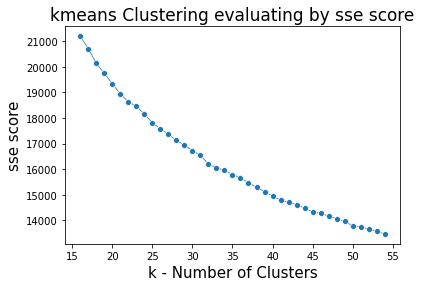

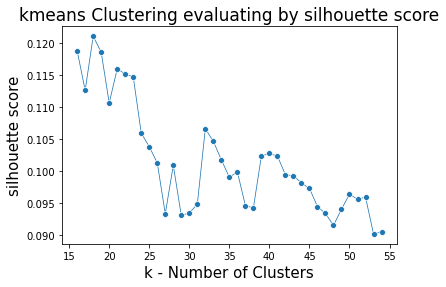

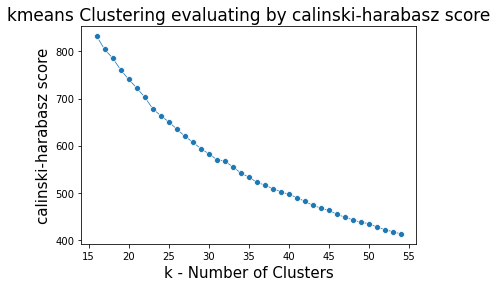

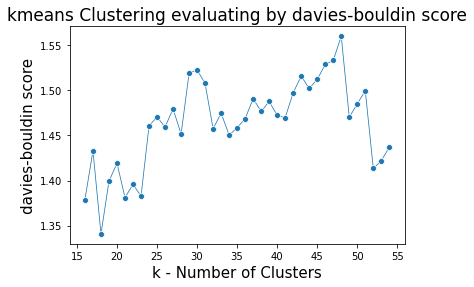

In [38]:
df_tpm = df_avg_log_ratio_scaled_tpm
x_min = 16
x_max = 55

scan_results = scan_kmeans_space(df_tpm, x_min, x_max)

elbow_locations_kmeans = []

for index, score_method in enumerate(standard_cluster_evals):
    clustering_method = 'kmeans'
    score_type = score_method
    kmeans_scores = score_generator(clustering_method, score_type, scan_results, df_tpm)

    plt.figure(index)
    scores = kmeans_scores
    x_label = "k - Number of Clusters" 
    y_label = score_type + " score" 
    title = "kmeans Clustering evaluating by " + score_type + " score" 
    
    df_scores = pd.DataFrame(scores)
    scores_y = df_scores[0]
    num_clusters_x = df_scores[1]
    
    cur_knee = KneeLocator(num_clusters_x, scores_y, curve='convex', direction='decreasing')
    elbow_locations_kmeans.append([score_method, cur_knee.knee])
    
    plot_partitional_scores(scores, x_label, y_label, title)

In [39]:
elbow_locations_kmeans

[['sse', 32],
 ['silhouette', 17],
 ['calinski-harabasz', 34],
 ['davies-bouldin', 16]]

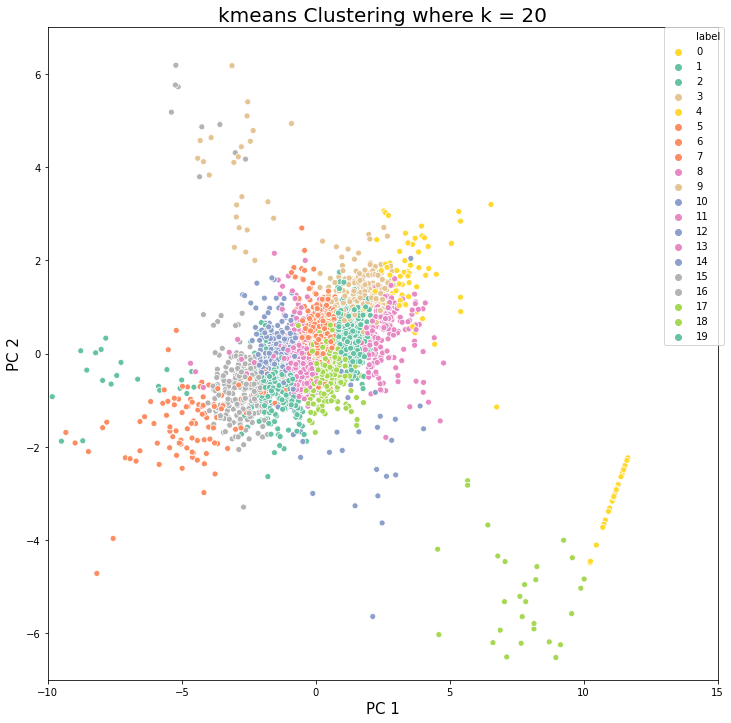

In [94]:
n_clusters = 20
data = df_avg_log_ratio
xlim = [-10, 15]
ylim = [-7, 7]
figsize = (12, 12)
check_altair = False
method = "kmeans"

kMeans_labels = plot_partitional_method(n_clusters, data, xlim, ylim, figsize, check_altair, method)

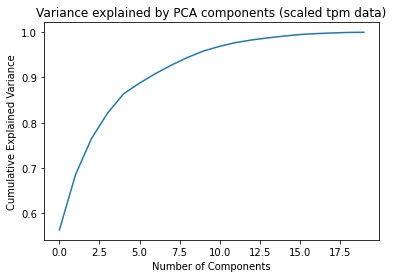

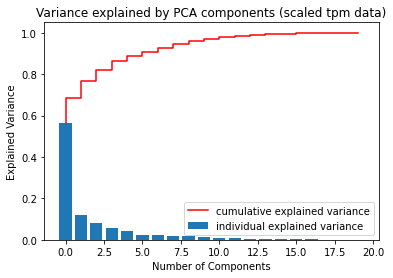

In [41]:
# draw basic matplotlib plots of variance explained and projections
pca_explained = PCA(20)
pca_explained.fit_transform(df_avg_log_ratio)
plot_pca_var(pca_explained, tag = "scaled tpm data")

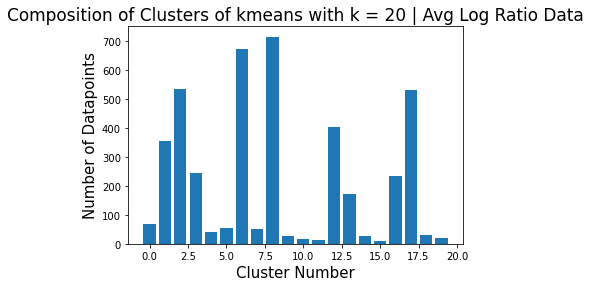

In [95]:
# COMPANION PLOT: Histogram of cluster composition

cluster_details = np.unique(kMeans_labels, return_counts=True)
title_add = "kmeans with k = 20 | Avg Log Ratio Data"
clusterCompositionPlot(cluster_details[0], cluster_details[1], title_add)

## DBSCAN

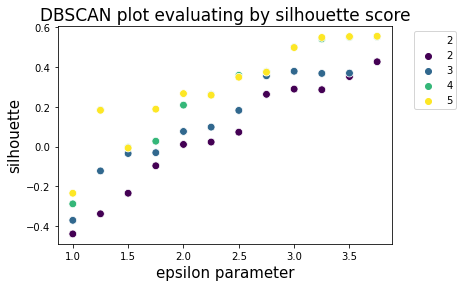

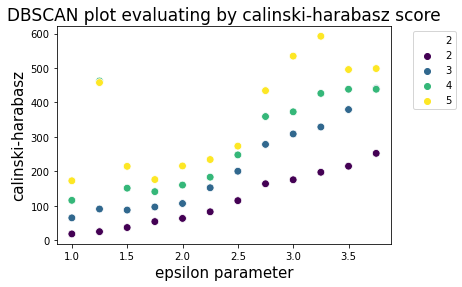

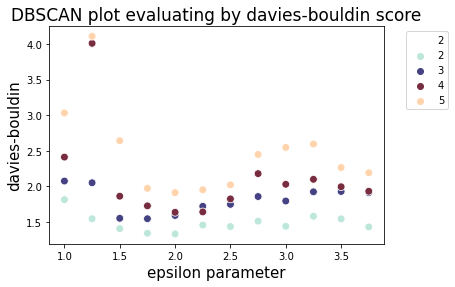

In [44]:
df_tpm = df_avg_log_ratio_scaled_tpm
eps_start = 1
eps_end = 4
min_sample_start = 2
min_sample_end = 6 

scan_results = scan_dbscan_space(df_tpm, eps_start, eps_end, min_sample_start, min_sample_end)

for score_method in standard_cluster_evals:
    if score_method != "sse":
        clustering_method = 'dbscan'
        score_type = score_method
        dbscan_scores = score_generator(clustering_method, score_type, scan_results, df_tpm)

        scores = dbscan_scores
        x_label = "epsilon parameter" 
        y_label = score_method
        title = "DBSCAN plot evaluating by " + score_type + " score"
        palette = "viridis"
        if score_type == "davies-bouldin": 
            palette = "icefire"
        plot_dbscan_scores(scores, x_label, y_label, title, palette)

# In Practice: Standard Clustering Algorithms

# Comparative Evaluation: Standard Clustering Algorithms

# Advanced Clustering Algorithms

In [45]:
from sklearn_extra.cluster import KMedoids

## Partitional clustering with kMeans and Density-based clustering with DBSCAN have already been explored
It is difficult to outline the success of these rudimentary clustering algorithms when more complex, nuanced algorithms based on "Hierarchical Clustering," "Partitional Clustering with Medoids," and "Bayesian Mixture Models"

## Hierarchical Clustering -  Agglomerative

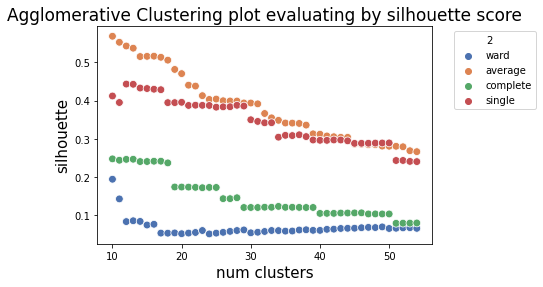

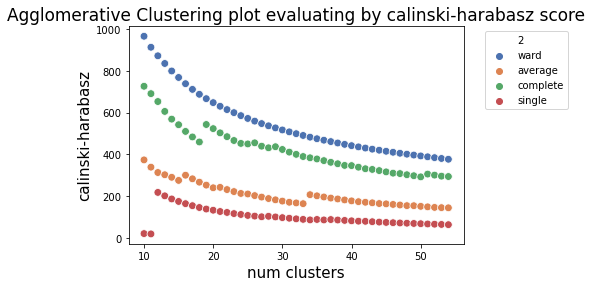

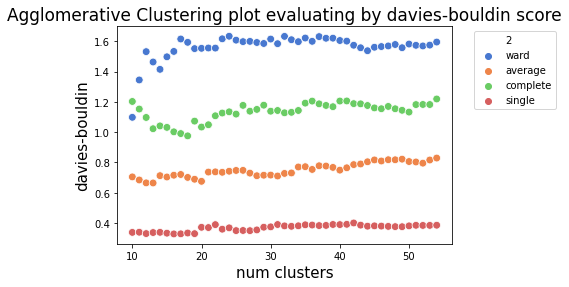

In [46]:
df_tpm = df_avg_log_ratio_scaled_tpm
linkage_methods = ['ward', 'average', 'complete', 'single']
x_min = 10
x_max = 55

scan_results = scan_agglomerative_space(df_tpm, linkage_methods, x_min, x_max)


for score_method in standard_cluster_evals:
    if score_method != "sse":
        clustering_method = 'agglomerative'
        score_type = score_method
        agg_scores = score_generator(clustering_method, score_type, scan_results, df_tpm)

        scores = agg_scores
        x_label = "num clusters" 
        y_label = score_method
        title = "Agglomerative Clustering plot evaluating by " + score_type + " score"
        palette = "deep"
        if score_type == "davies-bouldin": 
            palette = "muted"
        plot_agglomerative_scores(scores, x_label, y_label, title, palette)

**Notes**

- Linkage (the way distances between clusters are outlined)
    - Single: closest elements in clusters (creates long chains)
    - Complete: distance b/w farthest elements in clusters (creates sperical clusters)
    - Average: averages the pairwise distances of every single point in each clusters (less impact by outliers)
    - Ward's Method: uses the same method as kMeans (measure deviation of centroid to their comprising points) 
- Num Clusters: point at which the dendrogram is sliced (note workspace slides)



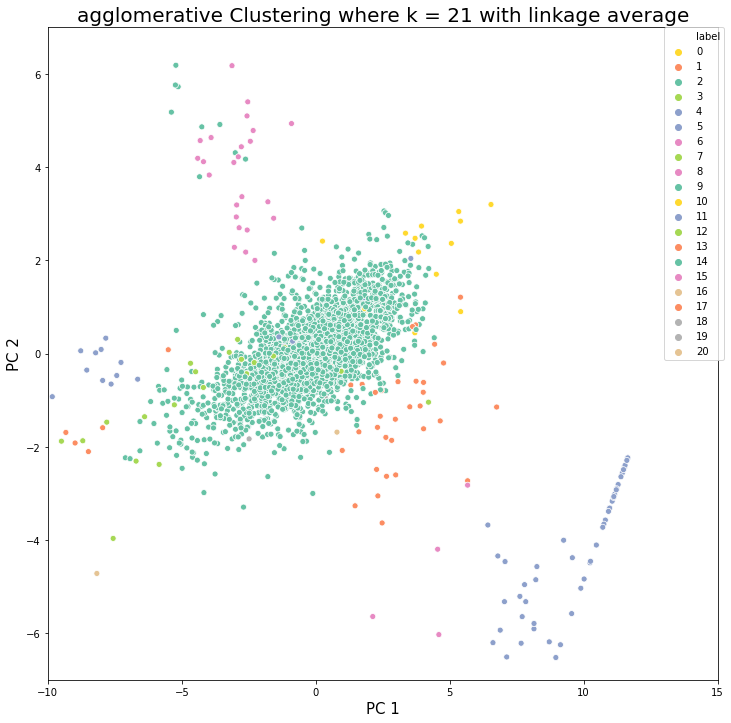

In [86]:
# 35, ward gives best ch eval metrics
# 16, standard gives best silhouette metric
# 19, single gives one of the best davies bouldin

n_clusters = 21
linkage = "average"
data = df_avg_log_ratio
xlim = [-10, 15]
ylim = [-7, 7]
figsize = (12, 12)
check_altair = False
method = "agglomerative"

agglomerative_labels = plot_hierarchical_method(n_clusters, linkage, None, data, xlim, ylim, figsize, check_altair, method)



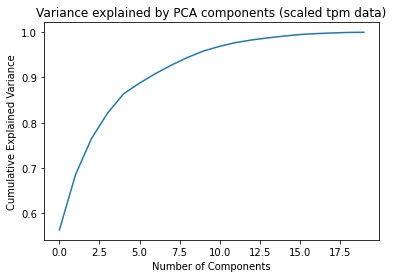

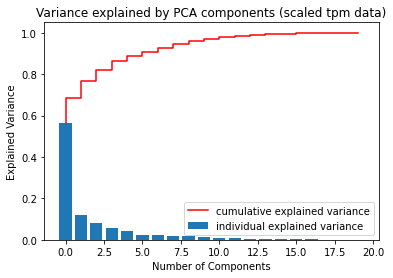

In [76]:
# draw basic matplotlib plots of variance explained and projections
pca_explained = PCA(20)
pca_explained.fit_transform(df_avg_log_ratio)
plot_pca_var(pca_explained, tag = "scaled tpm data")

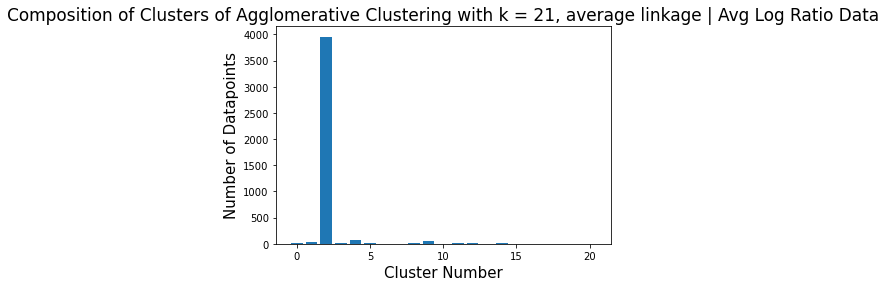

In [87]:
# COMPANION PLOT: Histogram of cluster composition

cluster_details = np.unique(agglomerative_labels, return_counts=True)
title_add = "Agglomerative Clustering with k = 21, average linkage | Avg Log Ratio Data"
clusterCompositionPlot(cluster_details[0], cluster_details[1], title_add)

## Density-Based Clustering - OPTICS

In [ ]:
n_clusters = 21
linkage = "average"
data = df_avg_log_ratio
xlim = [-10, 15]
ylim = [-7, 7]
figsize = (12, 12)
check_altair = False
method = "agglomerative"

agglomerative_labels = plot_hierarchical_method(n_clusters, linkage, None, data, xlim, ylim, figsize, check_altair, method)



## Hierarchical Clustering - BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies)

In [50]:
from sklearn.cluster import Birch

df_tpm = df_avg_log_ratio_scaled_tpm
threshold_min = 0.43
threshold_max = 0.57
branching_factor_min = 45
branching_factor_max = 55
x_min = 10
x_max = 35

scan_results = scan_birch_space(df_tpm, threshold_min, threshold_max, branching_factor_min, branching_factor_max, x_min, x_max)


for score_method in standard_cluster_evals:
    if score_method != "sse":
        clustering_method = 'birch'
        score_type = score_method
        agg_scores = score_generator(clustering_method, score_type, scan_results, df_tpm)

        scores = agg_scores
        x_label = "Number of Clusters (k)" 
        y_label = score_method
        title = "BIRCH Clustering plot evaluating by " + score_type + " score"
        palette = "deep"
        if score_type == "davies-bouldin": 
            palette = "muted"

        plot_birch_scores(scores, x_label, y_label, title, palette, score_type).display()
        
    


alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

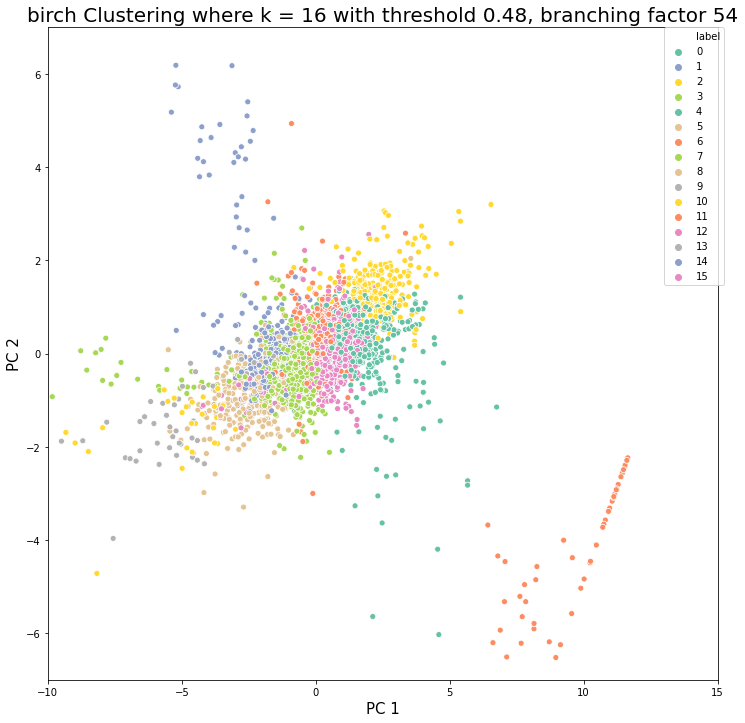

In [90]:


data = df_avg_log_ratio
xlim = [-10, 15]
ylim = [-7, 7]
figsize = (12, 12)
threshold = 0.48
branching_factor = 54
n_clusters = 16
check_altair = False
method = "birch"

birch_labels = plot_hierarchical_method(threshold, branching_factor, n_clusters, data, xlim, ylim, figsize, check_altair, method)



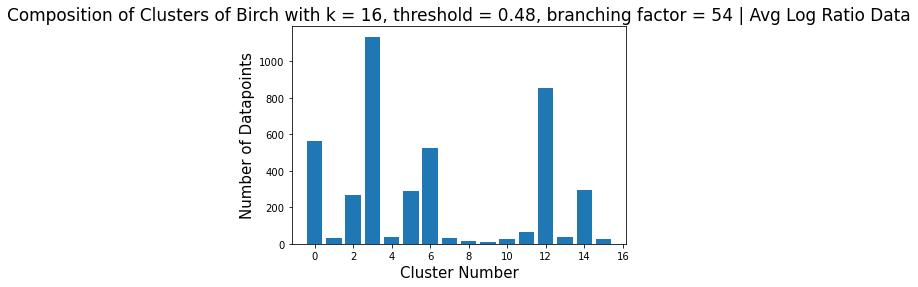

In [91]:
# COMPANION PLOT: Histogram of cluster composition

cluster_details = np.unique(birch_labels, return_counts=True)
title_add = "Birch with k = 16, threshold = 0.48, branching factor = 54 | Avg Log Ratio Data"
clusterCompositionPlot(cluster_details[0], cluster_details[1], title_add)

## Paritional Clustering - kMedoids (or PAM --> Partitioning Around Medoids)

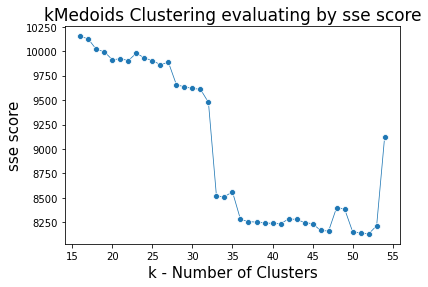

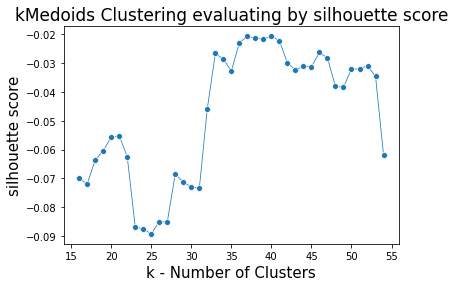

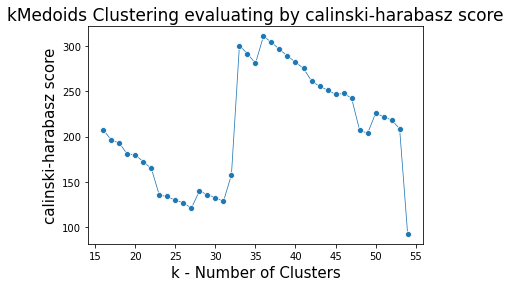

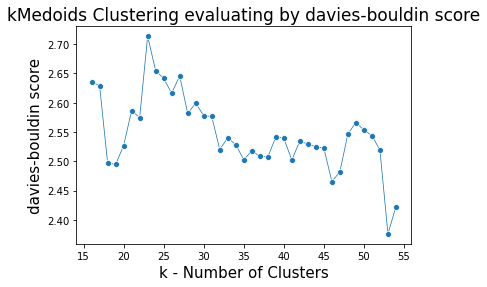

In [53]:
df_tpm = df_avg_log_ratio_scaled_tpm
x_min = 16
x_max = 55

scan_results = scan_kmedoids_space(df_tpm, x_min, x_max)

elbow_locations_kmedoids = []

for index, score_method in enumerate(standard_cluster_evals):
    clustering_method = 'kmedoids'
    score_type = score_method
    kmeans_scores = score_generator(clustering_method, score_type, scan_results, df_tpm)

    plt.figure(index)
    scores = kmeans_scores
    x_label = "k - Number of Clusters" 
    y_label = score_type + " score" 
    title = "kMedoids Clustering evaluating by " + score_type + " score" 
    
    
    df_scores = pd.DataFrame(scores)
    scores_y = df_scores[0]
    num_clusters_x = df_scores[1]
    
    cur_knee = KneeLocator(num_clusters_x, scores_y, curve='convex', direction='decreasing')
    elbow_locations_kmedoids.append([score_method, cur_knee.knee])
    
    
    plot_partitional_scores(scores, x_label, y_label, title)

In [54]:
elbow_locations_kmedoids

[['sse', 20],
 ['silhouette', 17],
 ['calinski-harabasz', 23],
 ['davies-bouldin', 18]]

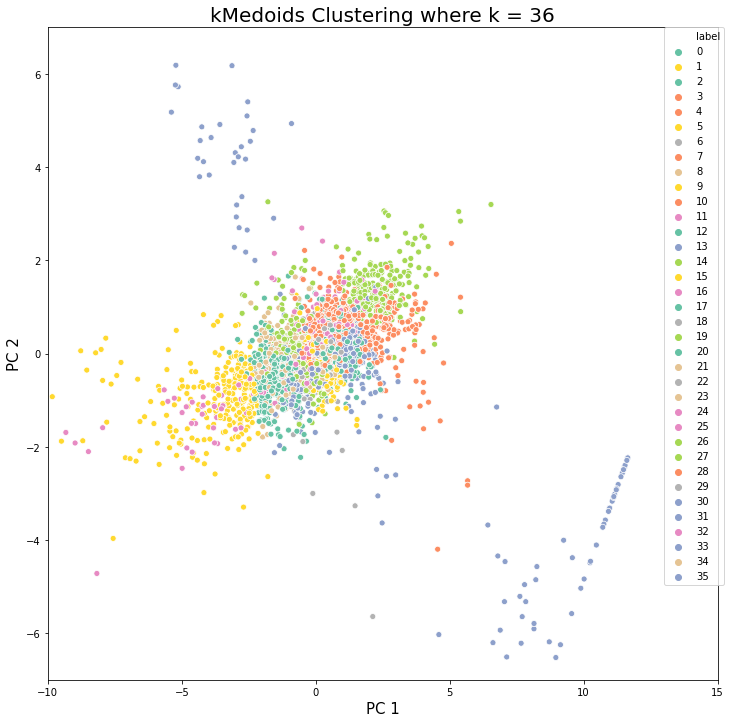

In [88]:
n_clusters = 36
data = df_avg_log_ratio
xlim = [-10, 15]
ylim = [-7, 7]
figsize = (12, 12)
check_altair = False
method = "kMedoids"

kMedoids_labels = plot_partitional_method(n_clusters, data, xlim, ylim, figsize, check_altair, method)




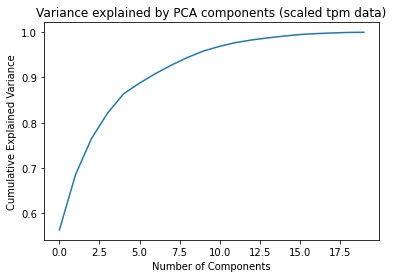

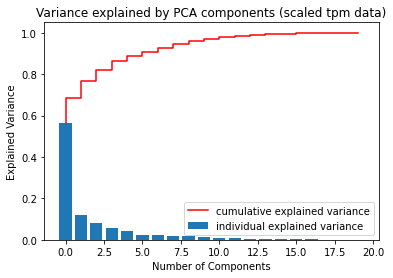

In [56]:
# draw basic matplotlib plots of variance explained and projections
pca_explained = PCA(20)
pca_explained.fit_transform(df_avg_log_ratio)
plot_pca_var(pca_explained, tag = "scaled tpm data")

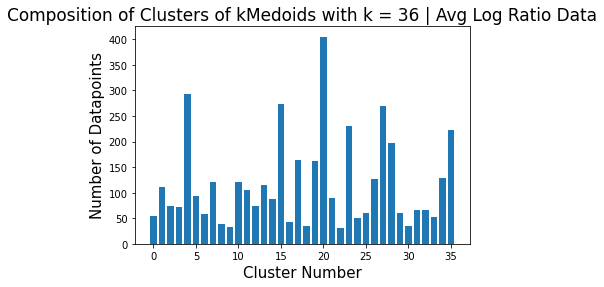

In [89]:
# COMPANION PLOT: Histogram of cluster composition

cluster_details = np.unique(kMedoids_labels, return_counts=True)
title_add = "kMedoids with k = 36 | Avg Log Ratio Data"
clusterCompositionPlot(cluster_details[0], cluster_details[1], title_add)

**Results**

-  

In [58]:
a = [[0.133, 0.245, 5, 32], ['d', 'e', 'm', 'p']]

da = pd.DataFrame(a)
da.columns = ['sil','eps', 'min_sample','num_cluster']
da
b = [[87, 0.245, 5, 32], ['d', 'f', 'l', 'p']]
db = pd.DataFrame(b)
db.columns = ['davies','eps', 'min_sample','num_cluster']

x = pd.merge(left=da, right= db, on=['eps', 'min_sample','num_cluster'], how = "inner")

dc = pd.DataFrame([[0.143, 22]])
dc.columns = ['sil','num_cluster']

l = pd.DataFrame(columns= ["num_cluster", "sil", "eps", "min_sample"])

dc = dc.append(x)
l.append(dc)

,num_cluster,sil,eps,min_sample,davies
0,22,0.143,NaN,NaN,NaN
0,32,0.133,0.245,5,87


In [59]:

df_tpm = df_avg_log_ratio_scaled_tpm

eps_start = 3
eps_end = 4
min_sample_start = 5
min_sample_end = 6 

scan_dbscan_results = scan_dbscan_space(df_tpm, eps_start, eps_end, min_sample_start, min_sample_end)

dbscan_sse_scores = pd.DataFrame(score_generator(method, "silhouette", scan_dbscan_results, df_tpm))
# dbscan_sse_scores.columns = ['sse', 'eps', 'min_sample', 'num_clusters']
# dbscan_sse_scores['method'] = method
dbscan_sse_scores

,0,1,2
0,0.497990,3.00,5
1,0.548724,3.25,5
2,0.553225,3.50,5
3,0.554784,3.75,5


# Testing Ideal Clusters

In [71]:
# load cluster data
top_clusters_file = 'data/top_cluster_selections.csv'

# load TPM data
df_top_clusters = pd.read_csv(top_clusters_file).fillna('')
df_top_clusters

,method,num_clusters,eps,min_samples,Linkage,Threshold,Branching_Factor
0,kmeans,19,,,,,
1,kmeans,20,,,,,
2,kmeans,32,,,,,
3,kmeans,36,,,,,
4,kmeans,40,,,,,
5,agglomerative,12,,,ward,,
6,agglomerative,17,,,ward,,
7,agglomerative,19,,,complete,,
8,agglomerative,12,,,single,,
9,agglomerative,19,,,single,,


In [61]:
iterable_best_clusterings = df_top_clusters.values.tolist()
iterable_best_clusterings

[['kmeans', 19.0, '', '', '', '', ''],
 ['kmeans', 20.0, '', '', '', '', ''],
 ['kmeans', 32.0, '', '', '', '', ''],
 ['kmeans', 36.0, '', '', '', '', ''],
 ['kmeans', 40.0, '', '', '', '', ''],
 ['agglomerative', 12.0, '', '', 'ward', '', ''],
 ['agglomerative', 17.0, '', '', 'ward', '', ''],
 ['agglomerative', 19.0, '', '', 'complete', '', ''],
 ['agglomerative', 12.0, '', '', 'single', '', ''],
 ['agglomerative', 19.0, '', '', 'single', '', ''],
 ['agglomerative', 21.0, '', '', 'average', '', ''],
 ['kmedoids', 23.0, '', '', '', '', ''],
 ['kmedoids', 33.0, '', '', '', '', ''],
 ['kmedoids', 36.0, '', '', '', '', ''],
 ['kmedoids', 49.0, '', '', '', '', ''],
 ['birch', 18.0, '', '', '0.53', 48.0, ''],
 ['birch', 19.0, '', '', '0.53', 51.0, ''],
 ['birch', 24.0, '', '', '0.53', 54.0, ''],
 ['birch', 21.0, '', '', '0.43', 50.0, ''],
 ['birch', 31.0, '', '', '0.43', 50.0, ''],
 ['birch', 16.0, '', '', '0.48', 54.0, ''],
 ['birch', 31.0, '', '', '0.48', 50.0, ''],
 ['dbscan', '', 1.25, 

In [70]:
clusteringMethods = ["kmeans", "dbscan", "agglomerative", "birch", "kmedoids"]

columns ={
    "kmeans": {"sse": ['sse', 'num_clusters'], "silhouette": ['silhouette', 'num_clusters'], "ch": ['calinski-harabasz', 'num_clusters'], "db": ['davies-bouldin', 'num_clusters'], "merge": ['method', 'num_clusters']},
    "dbscan": {"silhouette": ['silhouette', 'eps', 'min_sample', 'num_clusters'], "ch": ['calinski-harabasz', 'eps', 'min_sample', 'num_clusters'], "db": ['davies-bouldin', 'eps', 'min_sample', 'num_clusters'], "merge": ['method', 'eps', 'min_sample', 'num_clusters']},
    "agglomerative": {"silhouette": ['silhouette', 'num_clusters', 'linkage'], "ch": ['calinski-harabasz',  'num_clusters', 'linkage'], "db": ['davies-bouldin',  'num_clusters', 'linkage'], "merge": ['method', 'num_clusters', 'linkage']},
    "birch": {"silhouette": ['silhouette', 'threshold', 'branching_factor', 'num_clusters'], "ch": ['calinski-harabasz', 'threshold', 'branching_factor', 'num_clusters'], "db": ['davies-bouldin', 'threshold', 'branching_factor', 'num_clusters'], "merge": ['method', 'threshold', 'branching_factor', 'num_clusters']},
    "kmedoids":{"sse": ['sse', 'num_clusters'], "silhouette": ['silhouette', 'num_clusters'], "ch": ['calinski-harabasz', 'num_clusters'], "db": ['davies-bouldin', 'num_clusters'], "merge": ['method', 'num_clusters']}
}
    

# Collect metrics 
df_metrics = pd.DataFrame(columns = ["method", "num_clusters", "sse", "silhouette", "calinski-harabasz", "davies-bouldin", "eps", "min_sample", "linkage", "threshold", "branching_factor"])

# Data
default_dataframe = [df_avg_log_ratio_scaled_tpm]
default_string_form = "average log ratio scaled"

df_tpm = df_avg_log_ratio_scaled_tpm

for num, clustering in enumerate(iterable_best_clusterings): 
        
    # standard_cluster_evals = ["sse", "silhouette", "calinski-harabasz", "davies-bouldin"]
    cur_method = clustering[0] 
    
    if cur_method == "kmeans":
        
        k_cluster_num = int(clustering[1])
        
        kmeans = KMeans(n_clusters = k_cluster_num, **kwargs_for_kmeans)

        kmeans.fit(df_tpm)
        
        scan_results = [[kmeans.labels_, k_cluster_num, kmeans.inertia_]]
        
    elif cur_method == "dbscan": 
        
        e_val = float(clustering[2])
        min_sample = int(clustering[3]) 
        
        dbscan = DBSCAN(eps= e_val, min_samples= min_sample)
        search_gene_clusters_dbscan = dbscan.fit(df_tpm)

        search_labels_dbscan = search_gene_clusters_dbscan.labels_
        num_clusters = len(set(search_labels_dbscan))

        scan_results = [[search_labels_dbscan, e_val, min_sample, num_clusters]]
        
    elif cur_method == "agglomerative": 
        
        k_cluster_num = int(clustering[1])
        linkage = clustering[4]
    
        agg_cluster = AgglomerativeClustering(linkage= linkage, n_clusters=k_cluster_num)

        agg_cluster.fit(df_tpm)

        scan_results = [[agg_cluster.labels_, k_cluster_num, linkage]]
        
    elif cur_method == "birch":
        
        t_val = float(clustering[4])
        bf_val = int(clustering[5])
        k_cluster_num = int(clustering[1])
        
        birch = Birch(threshold = t_val, branching_factor = bf_val, n_clusters = k_cluster_num)

        birch.fit(df_tpm)

        scan_results = [[birch.labels_, t_val, bf_val, k_cluster_num]]

    elif cur_method == "kmedoids":
        
        k_cluster_num = int(clustering[1])
        
        kmedoids = KMedoids(n_clusters= k_cluster_num,  random_state=0).fit(df_tpm)

        kmedoids.fit(df_tpm)
        
        scan_results = [[kmedoids.labels_, k_cluster_num, kmedoids.inertia_]]
    

        
    sil_scores = pd.DataFrame(score_generator(cur_method, "silhouette", scan_results, df_tpm))
    sil_scores.columns = columns[cur_method]['silhouette']
    sil_scores['method'] = cur_method

    ch_scores = pd.DataFrame(score_generator(cur_method, "calinski-harabasz", scan_results, df_tpm))
    ch_scores.columns = columns[cur_method]['ch']
    ch_scores['method'] = cur_method

    db_scores = pd.DataFrame(score_generator(cur_method, "davies-bouldin", scan_results, df_tpm))
    db_scores.columns = columns[cur_method]['db']
    db_scores['method'] = cur_method
    
            
    if cur_method == 'kmeans' or cur_method == 'kmedoids':
        sse_scores = pd.DataFrame(score_generator(cur_method, "sse", scan_results, df_tpm))
        sse_scores.columns = columns[cur_method]["sse"]      
        sse_scores['method'] = cur_method
    
        
        df_merged = pd.merge(left=sse_scores, right= sil_scores, on= columns[cur_method]['merge'], how = "inner")
        df_merged = pd.merge(left = df_merged, right = ch_scores,  on= columns[cur_method]['merge'], how = "inner")
        df_merged = pd.merge(left = df_merged, right = db_scores,  on= columns[cur_method]['merge'], how = "inner")
    
    else: 
        df_merged = pd.merge(left=sil_scores, right= ch_scores, on= columns[cur_method]['merge'], how = "inner")
        df_merged = pd.merge(left = df_merged, right = db_scores,  on= columns[cur_method]['merge'], how = "inner")


    df_metrics = df_metrics.append(df_merged)
    
    
        
df_metrics
        
    

,method,num_clusters,sse,silhouette,calinski-harabasz,davies-bouldin,eps,min_sample,linkage,threshold,branching_factor
0,kmeans,19,19750.008784,0.118622,761.054241,1.399284,NaN,NaN,NaN,NaN,NaN
0,kmeans,20,19343.501779,0.110686,740.613431,1.419179,NaN,NaN,NaN,NaN,NaN
0,kmeans,32,16194.776293,0.106664,566.852396,1.457466,NaN,NaN,NaN,NaN,NaN
0,kmeans,36,15671.712193,0.099928,522.312527,1.468662,NaN,NaN,NaN,NaN,NaN
0,kmeans,40,14943.653534,0.102796,496.321000,1.472255,NaN,NaN,NaN,NaN,NaN
0,agglomerative,12,NaN,0.083177,872.031230,1.531269,NaN,NaN,ward,NaN,NaN
0,agglomerative,17,NaN,0.053048,711.187373,1.614753,NaN,NaN,ward,NaN,NaN
0,agglomerative,19,NaN,0.173798,542.964694,1.072709,NaN,NaN,complete,NaN,NaN
0,agglomerative,12,NaN,0.443434,217.698238,0.330362,NaN,NaN,single,NaN,NaN
0,agglomerative,19,NaN,0.394825,138.103523,0.329829,NaN,NaN,single,NaN,NaN


In [72]:
df_metrics

df_metrics.to_csv("data/top_metrics.csv")

In [73]:
x_axis = "davies-bouldin:Q"
y_axis = "calinski-harabasz:Q"
size = "silhouette:Q"
title  = "Clustering Evaluation Metric Evaluation - top"
data = df_metrics 

plot1 = plot_cluster_evaluations(data, title, x_axis, y_axis, size)


alt.HConcatChart(...)

<Figure size 1440x1080 with 0 Axes>

In [78]:
plot1.save('data/adjusted_clustering_plot1.html', embed_options={'renderer':'svg'})

In [74]:
x_axis = "davies-bouldin:Q"
y_axis = "silhouette:Q"
size = "calinski-harabasz:Q"
title  = "Clustering Evaluation Metric Evaluation - top"
data = df_metrics 

plot2 = plot_cluster_evaluations(data, title, x_axis, y_axis, size)
plot2

alt.HConcatChart(...)

<Figure size 1440x1080 with 0 Axes>

In [79]:
plot1.save('data/adjusted_clustering_plot2.html', embed_options={'renderer':'svg'})

## Ideal Clusters

- Agglomerative k = 19 Single/Complete Linkage, k = 12 Single Linkage, k = 21 Average Linkage
- kMeans 19, 20
- Birch k = 16, th = 0.48, bf = 54
- kMedoids k = 36
- dbscan eps = 2.5, min_s = 4 --> 13 clusters

In [37]:
ideal_clusters = [["agglomerative", "single", 19], ["agglomerative", "complete", 19], ["agglomerative", "single", 12], ["agglomerative", "average", 21], 
                  ["kmeans", 19], ["kmeans", 20], 
                 ["birch", 0.48, 54, 16], ["birch", 0.48, 50, 31],
                 ["kmedoids", 36], 
                 ["dbscan", 2.5, 4]]

In [38]:
ideal_clusters

[['agglomerative', 'single', 19],
 ['agglomerative', 'complete', 19],
 ['agglomerative', 'single', 12],
 ['agglomerative', 'average', 21],
 ['kmeans', 19],
 ['kmeans', 20],
 ['birch', 0.48, 54, 16],
 ['birch', 0.48, 50, 31],
 ['kmedoids', 36],
 ['dbscan', 2.5, 4]]

# Saving Labels From Clusters

In [45]:

df_avg_log_ratio_scaled_tpm

exp_condition,LanzaTech,MeOH,NO3_lowO2_slow_growth,NoCu,NoLanthanum,WT_control,WithLanthanum,aa3_KO,crotonic_acid,highCu,highO2_slow_growth,lowCH4,lowCu,lowO2_fast_growth,lowO2_low_iron_fast_growth,lowO2_slow_growth,medCu,slow_growth,uMax,unknown
locus_tag,,,,,,,,,,,,,,,,,,,,
EQU24_RS00005,-0.515808,-0.012058,-0.480048,-0.163349,-0.648447,-0.037469,-0.491013,-0.410117,-0.485123,0.085206,0.060397,-0.186470,-0.136377,-0.203679,-0.487435,-0.243069,0.044174,-0.122244,0.185208,-0.620522
EQU24_RS00010,0.480568,-0.659004,-0.218643,0.075821,-0.485571,-0.114821,-0.462526,0.094641,-0.209870,0.873114,0.504025,-0.305931,0.204399,-0.103679,-0.283817,0.062219,0.461263,0.103303,0.191813,-0.798028
EQU24_RS00015,-1.072637,0.327816,-0.461533,-0.212764,-0.583017,-0.648530,-0.633792,-0.917224,-0.048206,0.220238,0.138747,-0.385615,-0.106453,0.142845,-0.057250,-0.235794,0.034638,-0.609406,0.158782,-0.753895
EQU24_RS00020,0.723618,-1.032390,0.072132,-0.253222,-0.352283,0.183488,-0.292974,0.144541,0.167185,0.346152,-0.108216,-0.132304,-0.051795,-0.311922,0.060748,-0.078771,0.169326,0.274118,0.198566,-0.532597
EQU24_RS00025,0.424262,-0.479325,0.028098,0.116538,-0.261659,0.082847,-0.454102,-0.051229,0.045575,0.265104,0.450111,0.011533,0.240761,-0.573878,0.722346,0.029248,0.311967,0.268652,0.181731,-0.011128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EQU24_RS22135,-0.445389,-0.627550,-1.170665,-0.396450,-1.877416,-0.819438,-1.715711,-0.966683,-0.144739,0.277257,-1.123350,0.097626,-0.295041,0.153868,0.071796,-0.825055,0.213758,-1.168263,0.206290,-0.784262
EQU24_RS22140,0.309593,-1.327737,-1.065740,-0.706776,-1.812366,-0.818297,-1.749368,-0.654022,-0.239402,-0.195778,-1.305006,-0.407547,-0.418638,0.243782,-0.820586,-0.906017,-0.091223,-0.946392,0.229381,-1.159766
EQU24_RS22145,-1.028264,-0.395724,-1.265702,-0.657315,-2.492508,-0.803695,-2.140667,-0.926349,-0.555916,-0.028408,-1.210127,0.079368,-0.380479,0.362696,-0.218650,-0.747930,0.020182,-0.861652,0.229635,-1.151259


In [40]:
def get_ideal_labels(ideal_clusters):

    labels = []
    
    for parameters in ideal_clusters: 
    
        method = parameters[0]

        if method == "agglomerative": 
            agg_cluster = AgglomerativeClustering(linkage= parameters[1], n_clusters=parameters[2])
            agg_cluster.fit(df_tpm)
            
            labels.append([method, agg_cluster.labels_, parameters[1], parameters[2]])

        elif method == "kmeans":
            kmeans = KMeans(n_clusters=parameters[1], **kwargs_for_kmeans)
            kmeans.fit(df_tpm)
            
            labels.append([method, kmeans.labels_, parameters[1]])
            

        elif method == "birch": 
            birch = Birch(threshold = parameters[1], branching_factor = parameters[2], n_clusters = parameters[3])
            birch.fit(df_tpm)
            
            labels.append([method, birch.labels_, parameters[1], parameters[2], parameters[3]])

        elif method == "kmedoids": 
            kmedoids = KMedoids(n_clusters= parameters[1],  random_state=0).fit(df_tpm)
            kmedoids.fit(df_tpm)
            
            labels.append([method, kmedoids.labels_, parameters[1]])

        elif method == "dbscan":
            dbscan = DBSCAN(eps= parameters[1], min_samples= parameters[2])
            clusters_dbscan = dbscan.fit(df_tpm)

            labels.append([method, clusters_dbscan.labels_, parameters[1], parameters[2]])

    return labels

In [41]:
ideal_labels = get_ideal_labels(ideal_clusters)

df_ideal_labels = pd.DataFrame(ideal_labels)
df_ideal_labels.columns = ["method", "labels", "param1", "param2", "param3"]
df_ideal_labels.to_pickle("data/ideal_labels")

df_ideal_labels

,method,labels,param1,param2,param3
0,agglomerative,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",single,19.0,NaN
1,agglomerative,"[7, 7, 7, 7, 7, 1, 7, 1, 1, 1, 1, 8, 7, 8, 7, ...",complete,19.0,NaN
2,agglomerative,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",single,12.0,NaN
3,agglomerative,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",average,21.0,NaN
4,kmeans,"[12, 4, 17, 4, 4, 1, 12, 7, 7, 7, 7, 12, 17, 9...",19,NaN,NaN
5,kmeans,"[18, 18, 17, 18, 18, 0, 5, 0, 0, 0, 0, 5, 3, 1...",20,NaN,NaN
6,birch,"[0, 6, 0, 6, 6, 14, 6, 14, 14, 14, 14, 6, 12, ...",0.48,54.0,16.0
7,birch,"[14, 14, 3, 14, 21, 5, 5, 21, 21, 21, 21, 5, 7...",0.48,50.0,31.0
8,kmedoids,"[25, 9, 20, 26, 9, 19, 18, 19, 19, 21, 21, 22,...",36,NaN,NaN
9,dbscan,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.5,4.0,NaN


# Stability Testing

In [86]:
stability_storage = []

for i in range(10):
    
    kmeans = KMeans(n_clusters= 19, **random_kwargs_for_kmeans)
    kmeans.fit(df_tpm)

    ch = score_generator("kmeans", "calinski-harabasz", [[kmeans.labels_, 19, kmeans.inertia_]], df_tpm)
    db = score_generator("kmeans", "davies-bouldin", [[kmeans.labels_, 19, kmeans.inertia_]], df_tpm)
    sil = score_generator("kmeans", "silhouette", [[kmeans.labels_, 19, kmeans.inertia_]], df_tpm)
    sse = score_generator("kmeans", "sse", [[kmeans.labels_, 19, kmeans.inertia_]], df_tpm)
    
    stability_storage.append([ch[0][0], db[0][0], sil[0][0], sse[0][0]])
    
df_stability_storage = pd.DataFrame(stability_storage)
df_stability_storage.columns = ["ch_score", "db_score", "sil_score", "sse_score"]
variance = df_stability_storage.var()
df_stability_storage

,ch_score,db_score,sil_score,sse_score
0,743.478289,1.517527,0.111377,20105.540934
1,738.863240,1.554719,0.104024,20200.985917
2,759.690345,1.410014,0.120375,19777.171463
3,758.068461,1.486171,0.102416,19809.525075
4,739.875867,1.547192,0.108298,20179.943474
5,748.918622,1.502585,0.111855,19994.117521
6,743.290946,1.487033,0.111063,20109.401139
7,757.736503,1.460366,0.114256,19816.167134
8,746.037111,1.451050,0.115284,20052.952221
9,741.080561,1.537487,0.110885,20155.001876


In [78]:
# KMeans -> k = 19 with optimized initialization + fixed randomness deterministic (what was used thus far)
variance

ch_score     3.263812e-25
db_score     4.980182e-32
sil_score    9.532381e-33
dtype: float64

In [87]:
# KMeans -> k = 19 with random start state + no fixed randomness deterministic
variance

ch_score        64.071089
db_score         0.002128
sil_score        0.000027
sse_score    26493.561635
dtype: float64

In [ ]:
stability_storage_med = []

for i in range(30):
    
    kmeans = KMedoids(n_clusters= 19, **random_kwargs_for_kmeans)
    kmeans.fit(df_tpm)

    ch = score_generator("kmeans", "calinski-harabasz", [[kmeans.labels_, 19, kmeans.inertia_]], df_tpm)
    db = score_generator("kmeans", "davies-bouldin", [[kmeans.labels_, 19, kmeans.inertia_]], df_tpm)
    sil = score_generator("kmeans", "silhouette", [[kmeans.labels_, 19, kmeans.inertia_]], df_tpm)
    #sse = score_generator("kmeans", "sse", [[kmeans.labels_, 19, kmeans.inertia_]], df_tpm)
    
    stability_storage_med.append([ch[0][0], db[0][0], sil[0][0]])
    
df_stability_storage_med = pd.DataFrame(stability_storage)
df_stability_storage_med.columns = ["ch_score", "db_score", "sil_score"]
variance_med = df_stability_storage_med.var()
df_stability_storage_med

# Scratch Work

In [ ]:

        
#         %
        
        

#         x_min = 2
#         x_max = 35

#         scan_kMeans_results = scan_kmeans_space(df_tpm, x_min, x_max)
        
#         kmeans_sse_scores = pd.DataFrame(score_generator(method, "sse", scan_kMeans_results, df_tpm))
#         kmeans_sse_scores.columns = ['sse', 'num_clusters']
#         kmeans_sse_scores['method'] = method
        
#         kmeans_sil_scores = pd.DataFrame(score_generator(method, "silhouette", scan_kMeans_results, df_tpm))
#         kmeans_sil_scores.columns = ['silhouette', 'num_clusters']
#         kmeans_sil_scores['method'] = method

#         kmeans_ch_scores = pd.DataFrame(score_generator(method, "calinski-harabasz", scan_kMeans_results, df_tpm))
#         kmeans_ch_scores.columns = ['calinski-harabasz', 'num_clusters']
#         kmeans_ch_scores['method'] = method

#         kmeans_db_scores = pd.DataFrame(score_generator(method, "davies-bouldin", scan_kMeans_results, df_tpm))
#         kmeans_db_scores.columns = ['davies-bouldin', 'num_clusters']
#         kmeans_db_scores['method'] = method
        
#         df_kMeans_merged = pd.merge(left=kmeans_sse_scores, right= kmeans_sil_scores, on=['method','num_clusters'], how = "inner")
#         df_kMeans_merged = pd.merge(left = df_kMeans_merged, right = kmeans_ch_scores,  on=['method','num_clusters'], how = "inner")
#         df_kMeans_merged = pd.merge(left = df_kMeans_merged, right = kmeans_db_scores,  on=['method','num_clusters'], how = "inner")

#         df_metrics = df_metrics.append(df_kMeans_merged)
#         #print(df_metrics)
        
#     #Cycles through the parameter search space for DBSCAN
#     elif method == "dbscan":
        
#         eps_start = 1
#         eps_end = 4
#         min_sample_start = 2
#         min_sample_end = 6 

#         scan_dbscan_results = scan_dbscan_space(df_tpm, eps_start, eps_end, min_sample_start, min_sample_end)
        
#         dbscan_sil_scores = pd.DataFrame(score_generator(method, "silhouette", scan_dbscan_results, df_tpm))
#         dbscan_sil_scores.columns = ['silhouette', 'eps', 'min_sample', 'num_clusters']
#         dbscan_sil_scores['method'] = method

#         dbscan_ch_scores = pd.DataFrame(score_generator(method, "calinski-harabasz", scan_dbscan_results, df_tpm))
#         dbscan_ch_scores.columns = ['calinski-harabasz', 'eps', 'min_sample', 'num_clusters']
#         dbscan_ch_scores['method'] = method

#         dbscan_db_scores = pd.DataFrame(score_generator(method, "davies-bouldin", scan_dbscan_results, df_tpm))
#         dbscan_db_scores.columns = ['davies-bouldin', 'eps', 'min_sample', 'num_clusters']
#         dbscan_db_scores['method'] = method
        
#         df_dbscan_merged = pd.merge(left=dbscan_sil_scores, right= dbscan_ch_scores, on=['method','eps', 'min_sample', 'num_clusters'], how = "inner")
#         df_dbscan_merged = pd.merge(left = df_dbscan_merged, right = dbscan_db_scores,  on=['method','eps', 'min_sample', 'num_clusters'], how = "inner")

#         df_metrics = df_metrics.append(df_dbscan_merged)

#     #Cycles through the parameter search space for Agglomerative clustering
#     elif method == "agglomerative":
        
#         linkage_methods = ['ward', 'average', 'complete', 'single']
#         x_min = 2
#         x_max = 35
#         scan_agglomerative_results = scan_agglomerative_space(df_tpm, linkage_methods, x_min, x_max)
        
#         agg_sil_scores = pd.DataFrame(score_generator(method, "silhouette", scan_agglomerative_results, df_tpm))
#         agg_sil_scores.columns = ['silhouette', 'num_clusters', 'linkage']
#         agg_sil_scores['method'] = method

#         agg_ch_scores = pd.DataFrame(score_generator(method, "calinski-harabasz", scan_agglomerative_results, df_tpm))
#         agg_ch_scores.columns = ['calinski-harabasz',  'num_clusters', 'linkage']
#         agg_ch_scores['method'] = method

#         agg_db_scores = pd.DataFrame(score_generator(method, "davies-bouldin", scan_agglomerative_results, df_tpm))
#         agg_db_scores.columns = ['davies-bouldin',  'num_clusters', 'linkage']
#         agg_db_scores['method'] = method
        
#         df_agg_merged = pd.merge(left= agg_sil_scores, right= agg_ch_scores, on=['method','num_clusters', 'linkage'], how = "inner")
#         df_agg_merged = pd.merge(left = df_agg_merged, right = agg_db_scores,  on=['method','num_clusters', 'linkage'], how = "inner")

#         df_metrics = df_metrics.append(df_agg_merged)
        
        
#     elif method == "birch":
        
#         df_tpm = df_avg_log_ratio_scaled_tpm
#         threshold_min = 0.43
#         threshold_max = 0.57
#         branching_factor_min = 45
#         branching_factor_max = 55
#         x_min = 10
#         x_max = 35

#         scan_birch_results = scan_birch_space(df_tpm, threshold_min, threshold_max, branching_factor_min, branching_factor_max, x_min, x_max)

#         birch_sil_scores = pd.DataFrame(score_generator(method, "silhouette", scan_birch_results, df_tpm))
#         birch_sil_scores.columns = ['silhouette', 'threshold', 'branching_factor', 'num_clusters']
#         birch_sil_scores['method'] = method

#         birch_ch_scores = pd.DataFrame(score_generator(method, "calinski-harabasz", scan_birch_results, df_tpm))
#         birch_ch_scores.columns = ['calinski-harabasz',  'threshold', 'branching_factor', 'num_clusters']
#         birch_ch_scores['method'] = method

#         birch_db_scores = pd.DataFrame(score_generator(method, "davies-bouldin", scan_birch_results, df_tpm))
#         birch_db_scores.columns = ['davies-bouldin',  'threshold', 'branching_factor', 'num_clusters']
#         birch_db_scores['method'] = method
        
#         df_birch_merged = pd.merge(left= birch_sil_scores, right= birch_ch_scores, on=['method','threshold', 'branching_factor', 'num_clusters'], how = "inner")
#         df_birch_merged = pd.merge(left = df_birch_merged, right = birch_db_scores,  on=['method','threshold', 'branching_factor', 'num_clusters'], how = "inner")

#         df_metrics = df_metrics.append(df_birch_merged)
        
#     elif method == "kmedoids":
#         df_tpm = df_avg_log_ratio_scaled_tpm
#         x_min = 2
#         x_max = 35

#         scan_kmedoids_results = scan_kmedoids_space(df_tpm, x_min, x_max)

#         kmedoids_sse_scores = pd.DataFrame(score_generator(method, "sse", scan_kmedoids_results, df_tpm))
#         kmedoids_sse_scores.columns = ['sse', 'num_clusters']
#         kmedoids_sse_scores['method'] = method
        
#         kmedoids_sil_scores = pd.DataFrame(score_generator(method, "silhouette", scan_kmedoids_results, df_tpm))
#         kmedoids_sil_scores.columns = ['silhouette', 'num_clusters']
#         kmedoids_sil_scores['method'] = method

#         kmedoids_ch_scores = pd.DataFrame(score_generator(method, "calinski-harabasz", scan_kmedoids_results, df_tpm))
#         kmedoids_ch_scores.columns = ['calinski-harabasz', 'num_clusters']
#         kmedoids_ch_scores['method'] = method

#         kmedoids_db_scores = pd.DataFrame(score_generator(method, "davies-bouldin", scan_kmedoids_results, df_tpm))
#         kmedoids_db_scores.columns = ['davies-bouldin', 'num_clusters']
#         kmedoids_db_scores['method'] = method
        
#         df_kmedoids_merged = pd.merge(left=kmedoids_sse_scores, right= kmedoids_sil_scores, on=['method','num_clusters'], how = "inner")
#         df_kmedoids_merged = pd.merge(left = df_kmedoids_merged, right = kmedoids_ch_scores,  on=['method','num_clusters'], how = "inner")
#         df_kmedoids_merged = pd.merge(left = df_kmedoids_merged, right = kmedoids_db_scores,  on=['method','num_clusters'], how = "inner")

#         df_metrics = df_metrics.append(df_kmedoids_merged)
        
    